In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics

plt.style.use('seaborn')
sns.set(font_scale=2)
pd.set_option('display.max_columns', 500)

In [2]:
DEBUG = False

if DEBUG:
    NROWS = 100000
else:
    NROWS = None

# 1. Read dataset

In [3]:
%%time
train = pd.read_csv('../input/train.csv', nrows=NROWS)

CPU times: user 7.82 s, sys: 712 ms, total: 8.53 s
Wall time: 8.54 s


## 1.1 Target  check

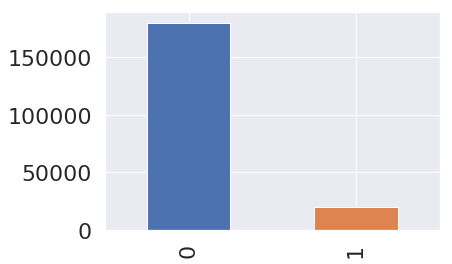

In [4]:
train['target'].value_counts().plot.bar()

- This competiiton is Imbalanced target competition.
- You can check similar competitions, Porto, Homecredit competition.
- Specially, Porto also gave use anonymized dataset. 
- https://www.kaggle.com/c/home-credit-default-risk
- https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

## 1.2 Null data check

In [5]:
%%time
# checking missing data
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

CPU times: user 2.44 s, sys: 132 ms, total: 2.58 s
Wall time: 2.41 s


In [6]:
missing_train_data

Total  Percent
var_199      0      0.0
var_61       0      0.0
var_71       0      0.0
var_70       0      0.0
var_69       0      0.0
var_68       0      0.0
var_67       0      0.0
var_66       0      0.0
var_65       0      0.0
var_64       0      0.0
var_63       0      0.0
var_62       0      0.0
var_60       0      0.0
var_48       0      0.0
var_59       0      0.0
var_58       0      0.0
var_57       0      0.0
var_56       0      0.0
var_55       0      0.0
var_54       0      0.0
var_53       0      0.0
var_52       0      0.0
var_51       0      0.0
var_50       0      0.0
var_72       0      0.0
var_73       0      0.0
var_74       0      0.0
var_75       0      0.0
var_96       0      0.0
var_95       0      0.0
...        ...      ...
var_104      0      0.0
var_103      0      0.0
var_102      0      0.0
var_101      0      0.0
var_122      0      0.0
var_124      0      0.0
var_147      0      0.0
var_125      0      0.0
var_146      0      0.0
var_145      0      0.0
var_144      0      0.0
var_143      0      0.0
var_142      0      0.0
var_141      0      0.0
var_140      0      0.0
var_139      0      0.0
var_138      0      0.0
var_137      0      0.0
var_136      0      0.0
var_135      0      0.0
var_134      0      0.0
var_133      0      0.0
var_132      0      0.0
var_131      0      0.0
var_130      0      0.0
var_129      0      0.0
var_128      0      0.0
var_127      0      0.0
var_126      0      0.0
ID_code      0      0.0

[202 rows x 2 columns]

- There is no missing values.
- Because we don't know the exact meaning of variables, we need to check some values as null value.

# 2. Exploratory Data Analysis

- Before EDA, let's group the features into category and non-category based on the number of uniqueness.

In [7]:
for col in train.columns[2:]:
    print("Number of unique values of {} : {}".format(col, train[col].nunique()))

Number of unique values of var_0 : 94672
Number of unique values of var_1 : 108932
Number of unique values of var_2 : 86555
Number of unique values of var_3 : 74597
Number of unique values of var_4 : 63515
Number of unique values of var_5 : 141029
Number of unique values of var_6 : 38599
Number of unique values of var_7 : 103063
Number of unique values of var_8 : 98617
Number of unique values of var_9 : 49417
Number of unique values of var_10 : 128764
Number of unique values of var_11 : 130193
Number of unique values of var_12 : 9561
Number of unique values of var_13 : 115181
Number of unique values of var_14 : 79122
Number of unique values of var_15 : 19810
Number of unique values of var_16 : 86918
Number of unique values of var_17 : 137823
Number of unique values of var_18 : 139515
Number of unique values of var_19 : 144180
Number of unique values of var_20 : 127764
Number of unique values of var_21 : 140062
Number of unique values of var_22 : 90660
Number of unique values of var_23 

- Oh, Most features have more than thousands of values for each variable except var_68 (435)

- Let's see var 68

In [8]:
train['var_68'].value_counts()

5.0214    1084
5.0215    1081
5.0209    1080
5.0183    1077
5.0179    1071
5.0208    1070
5.0193    1070
5.0202    1069
5.0174    1066
5.0203    1063
5.0189    1063
5.0195    1062
5.0220    1060
5.0204    1059
5.0211    1058
5.0188    1057
5.0157    1054
5.0158    1049
5.0219    1049
5.0190    1048
5.0201    1047
5.0221    1043
5.0207    1040
5.0192    1038
5.0212    1038
5.0184    1035
5.0205    1033
5.0151    1031
5.0185    1029
5.0197    1029
          ... 
4.9976       1
5.0415       1
5.0458       1
4.9951       1
5.0445       1
4.9995       1
5.0444       1
5.0000       1
5.0426       1
5.0421       1
4.9984       1
5.0419       1
5.0422       1
4.9964       1
5.0436       1
4.9979       1
4.9993       1
4.9977       1
5.0414       1
5.0418       1
5.0410       1
5.0412       1
4.9978       1
5.0469       1
4.9967       1
5.0407       1
5.0411       1
4.9938       1
4.9989       1
5.0431       1
Name: var_68, Length: 451, dtype: int64

- It also has float numbers. 
- Uncovering these values will be intersting job!
- Multiplying and dividing with some values can make the hidden categories, See Radder work(https://www.kaggle.com/raddar/target-true-meaning-revealed)

# 2.1 Correlation

In [9]:
corr = train.corr()

In [10]:
abs(corr['target']).sort_values(ascending=False)

target     1.000000
var_81     0.080917
var_139    0.074080
var_12     0.069489
var_6      0.066731
var_110    0.064275
var_146    0.063644
var_53     0.063399
var_26     0.062422
var_76     0.061917
var_174    0.061669
var_22     0.060558
var_21     0.058483
var_99     0.058367
var_166    0.057773
var_80     0.057609
var_190    0.055973
var_2      0.055870
var_165    0.055734
var_13     0.055156
var_148    0.055011
var_133    0.054548
var_198    0.053000
var_34     0.052692
var_0      0.052390
var_1      0.050343
var_115    0.050174
var_179    0.050002
var_109    0.049926
var_40     0.049530
             ...   
var_61     0.007407
var_182    0.007198
var_153    0.007103
var_73     0.006460
var_14     0.006332
var_60     0.006265
var_129    0.005880
var_46     0.005690
var_183    0.005467
var_160    0.005135
var_29     0.004682
var_124    0.004218
var_161    0.004168
var_39     0.004090
var_98     0.004074
var_158    0.003817
var_136    0.003554
var_96     0.003037
var_7      0.003025


- The largest correlation value is 0.08
- Actually, the target is binary and variables are continous, so correlation is not enough to judge. Let's see the distribution!

# 2.2 Distribution regarding to target

In [11]:
target_mask = train['target'] == 1
non_target_mask = train['target'] == 0 

In [12]:
from scipy.stats import ks_2samp

In [13]:
statistic, pvalue = ks_2samp(train.loc[non_target_mask, col], train.loc[target_mask, col])

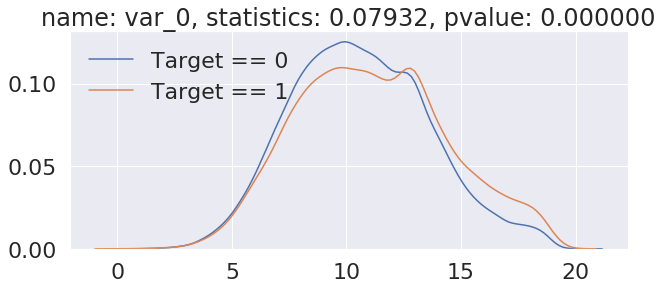

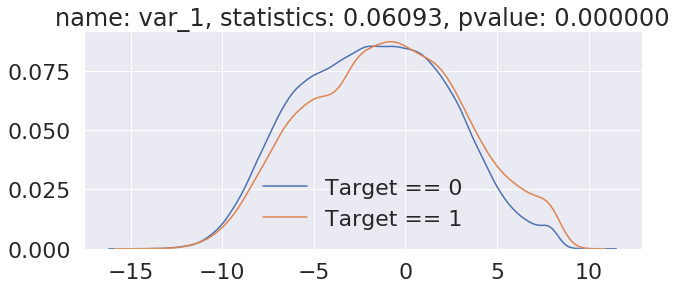

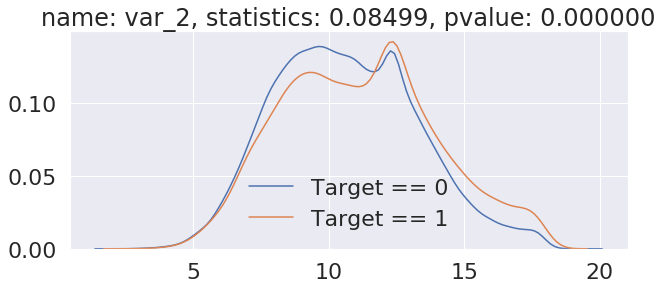

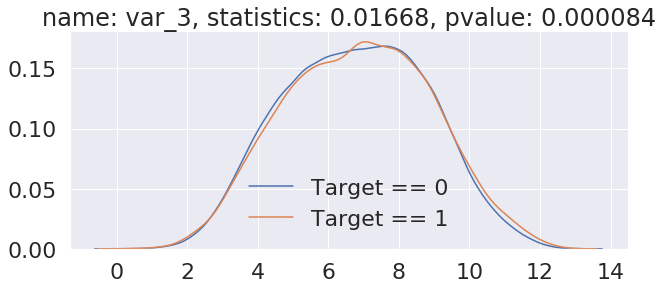

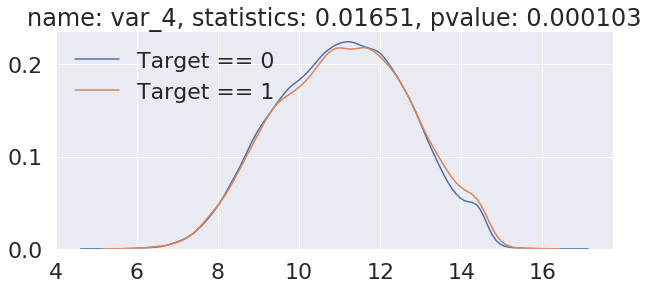

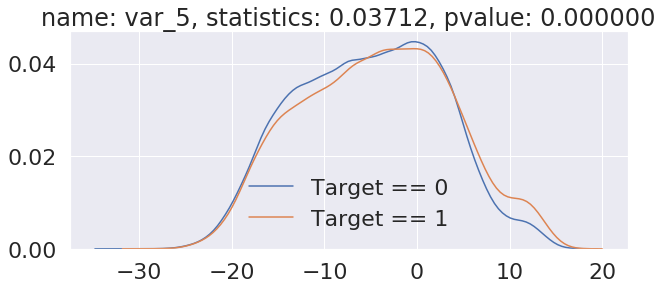

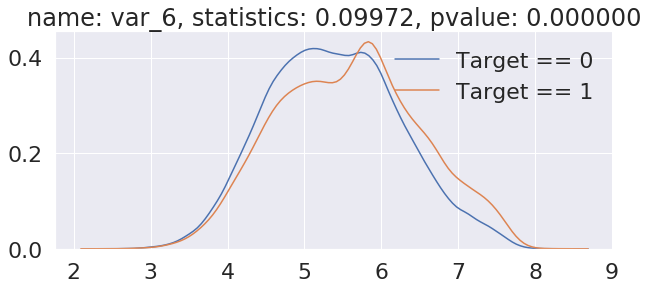

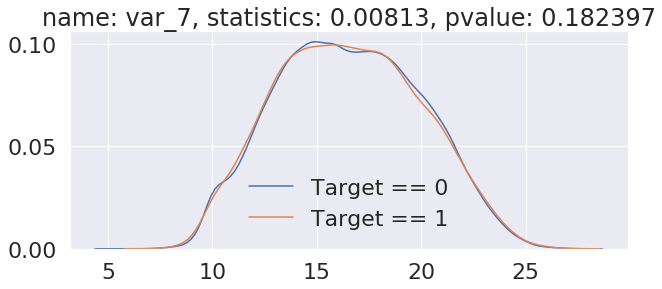

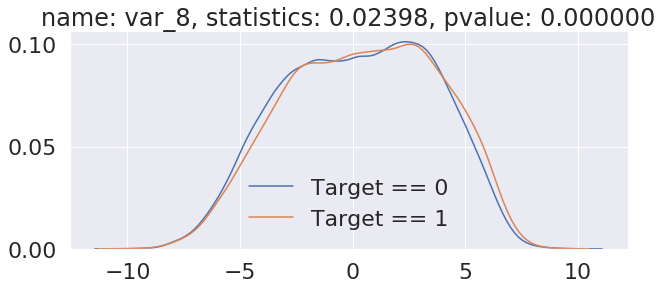

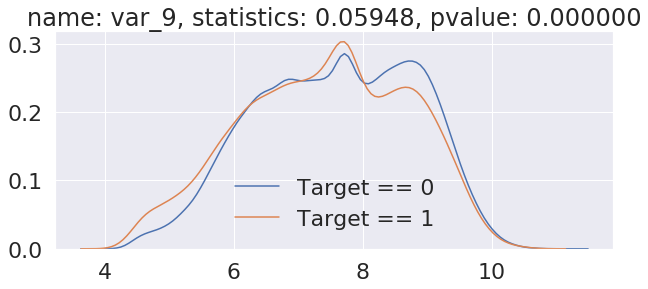

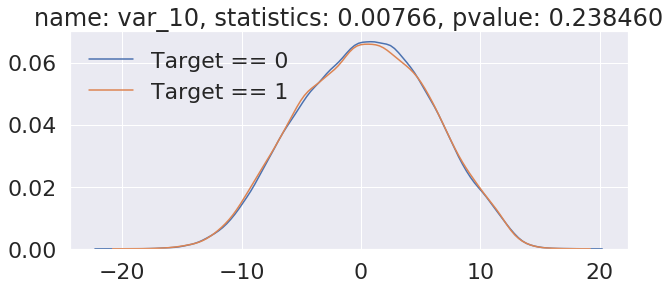

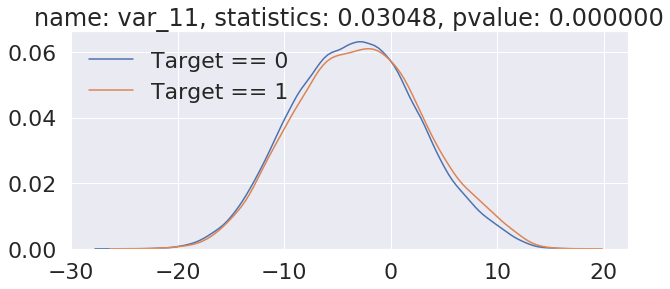

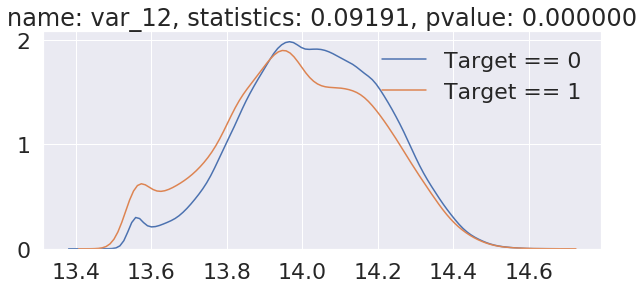

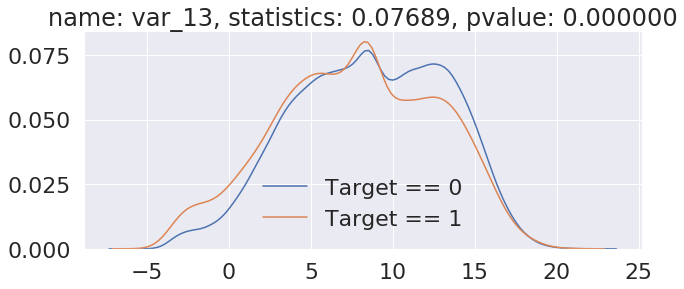

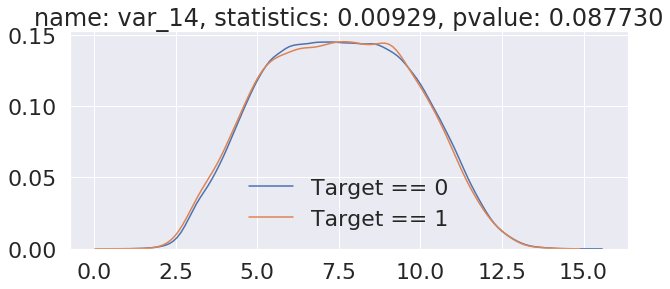

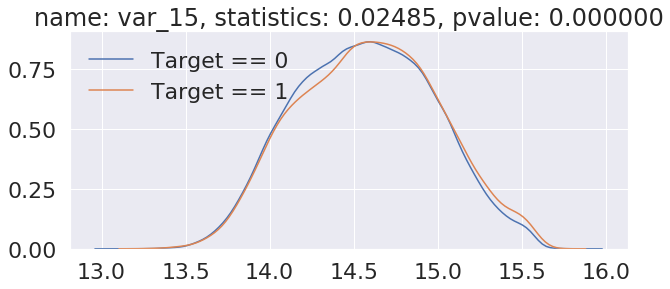

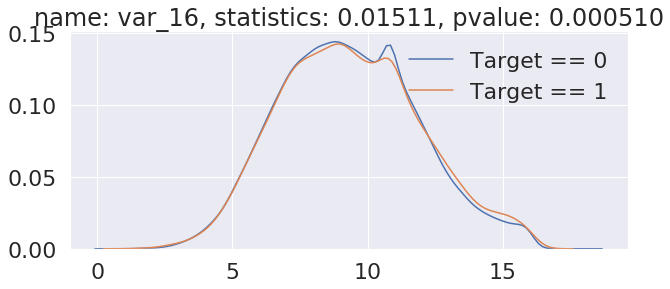

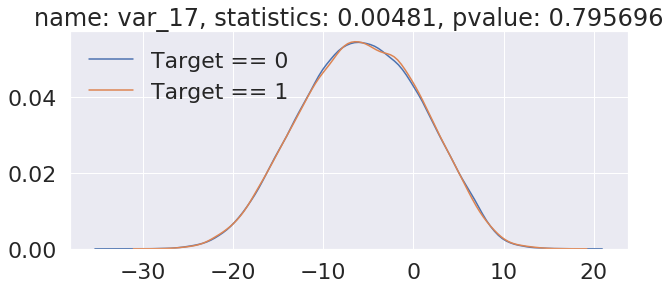

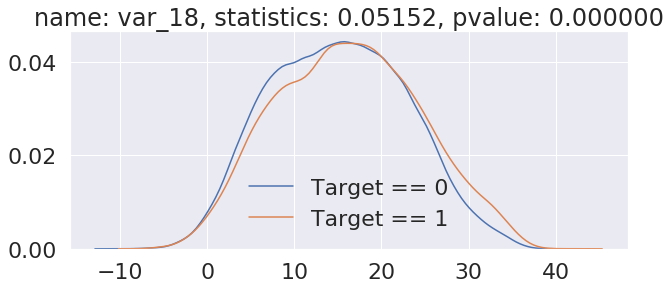

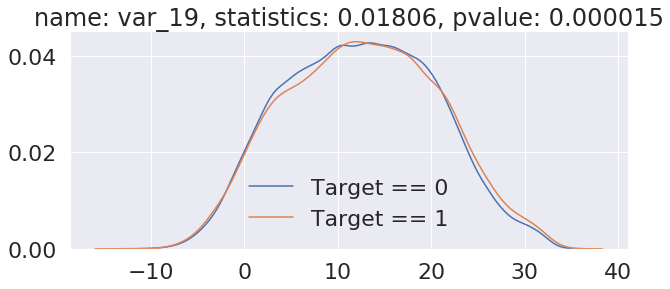

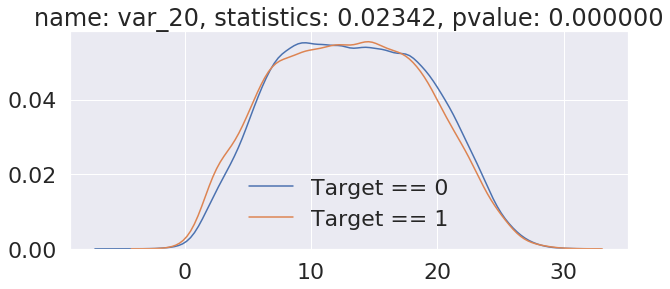

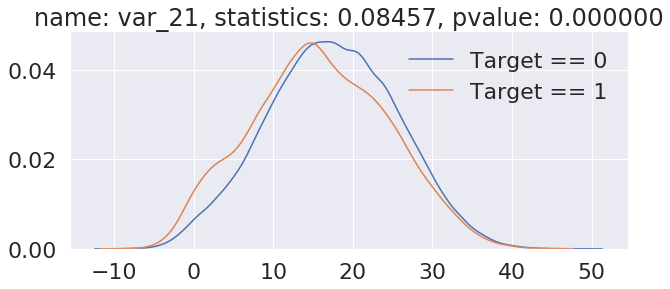

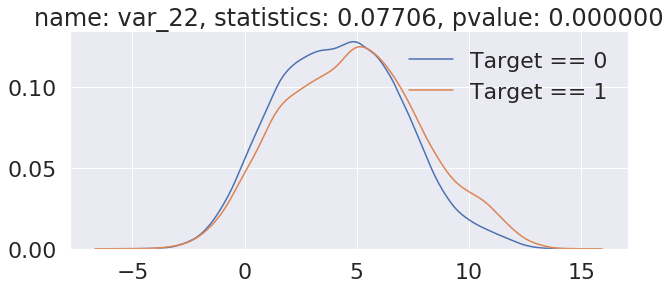

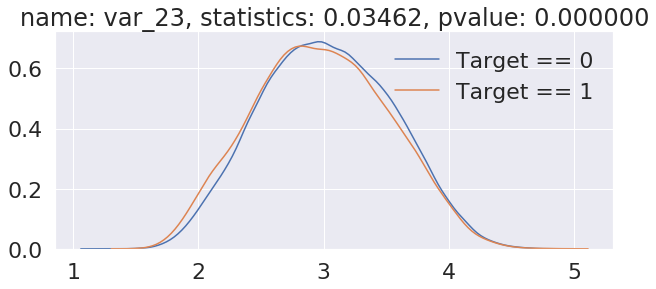

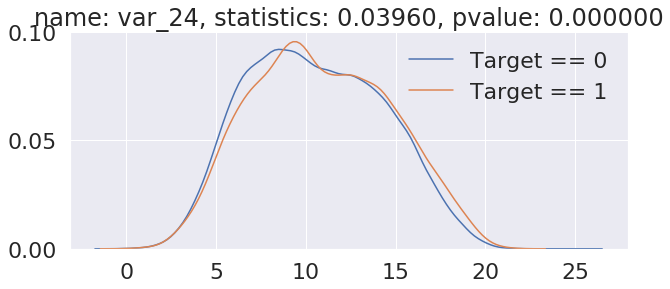

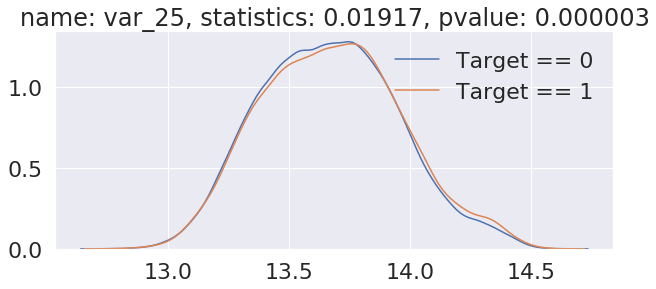

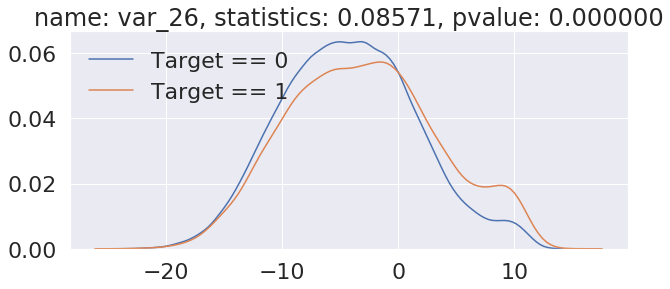

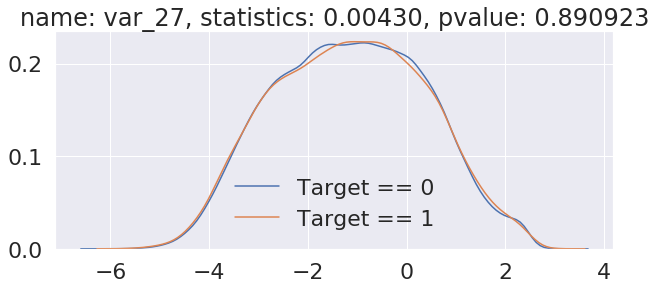

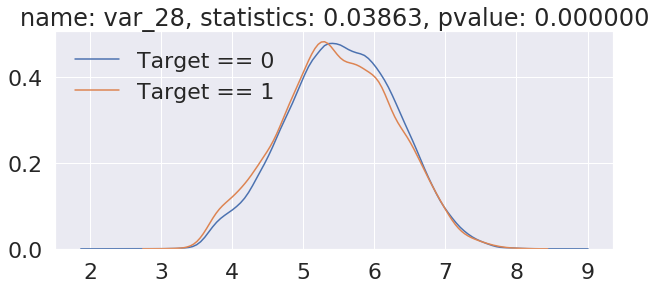

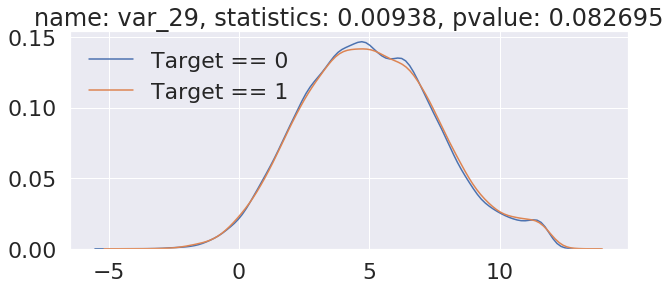

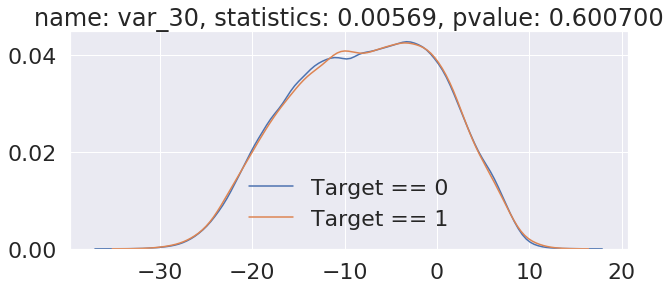

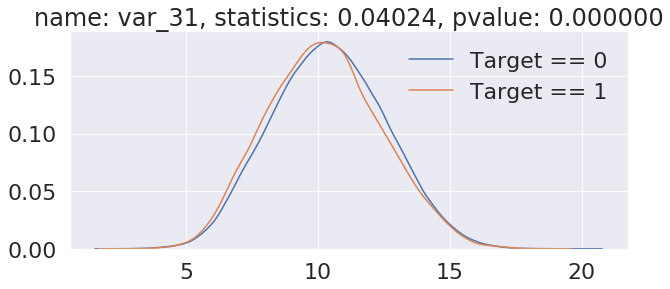

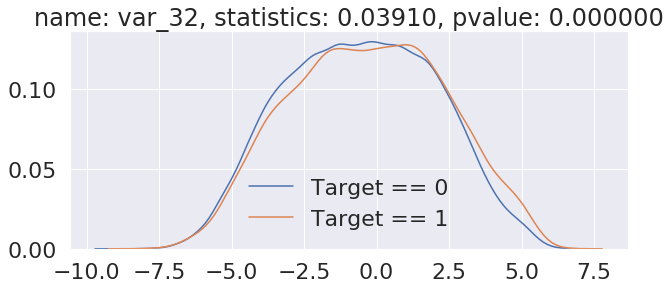

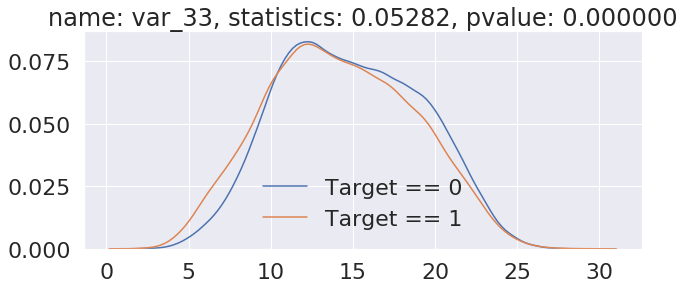

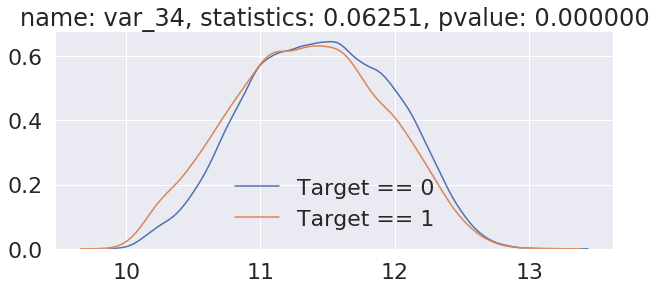

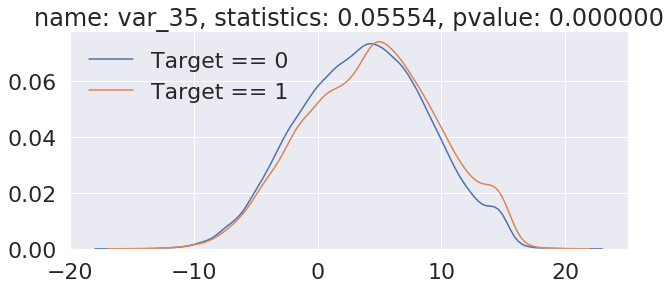

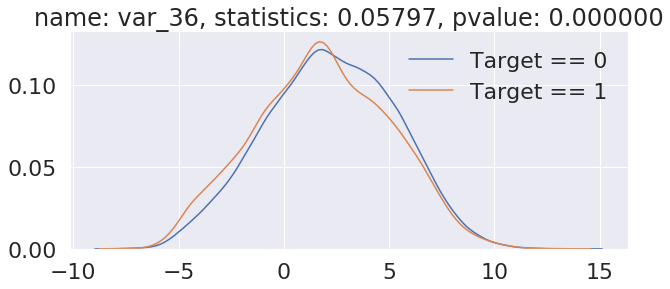

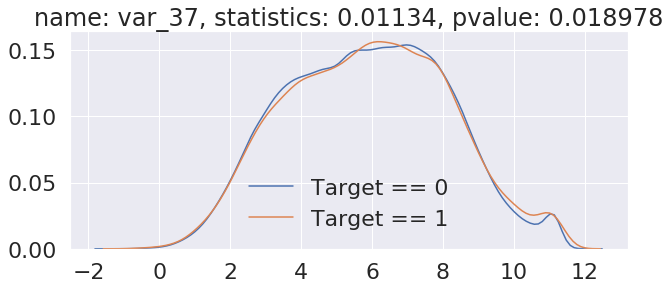

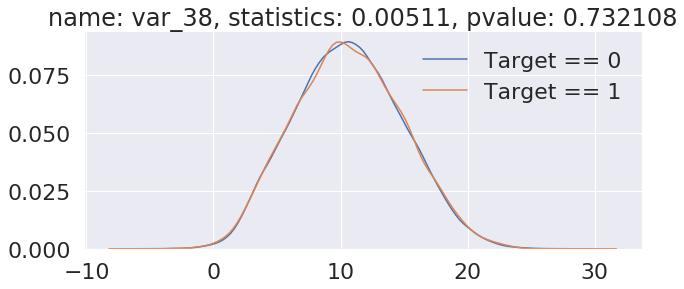

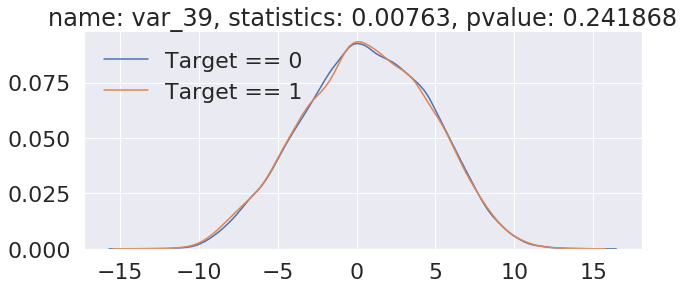

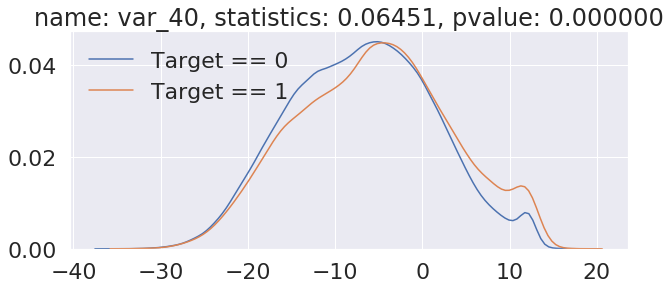

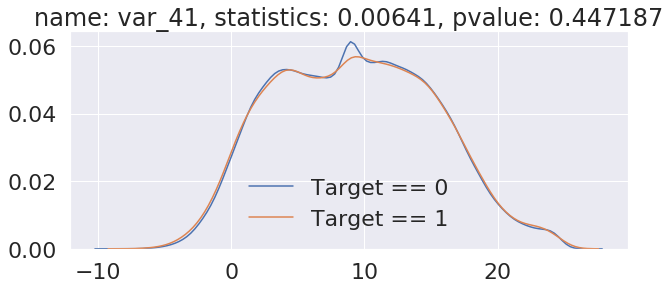

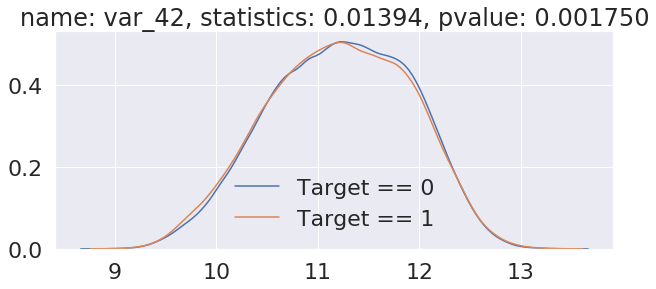

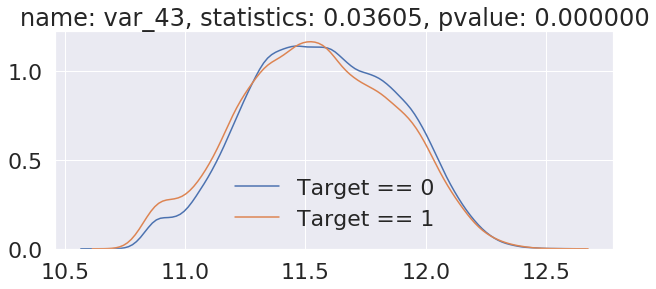

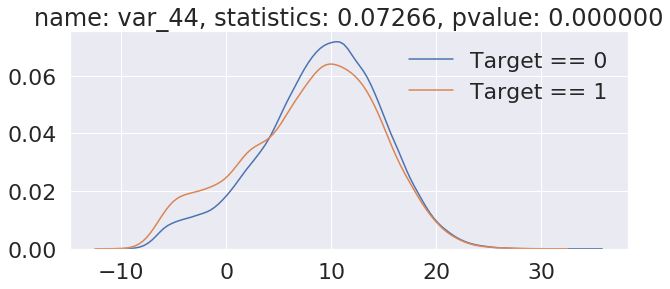

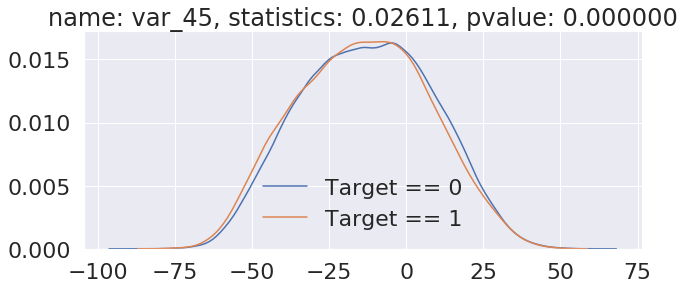

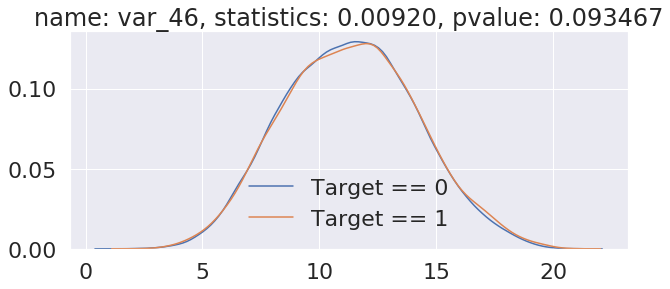

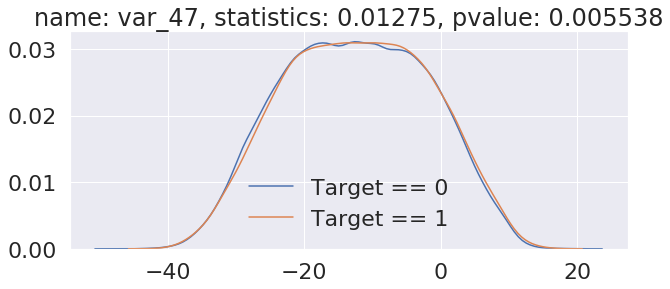

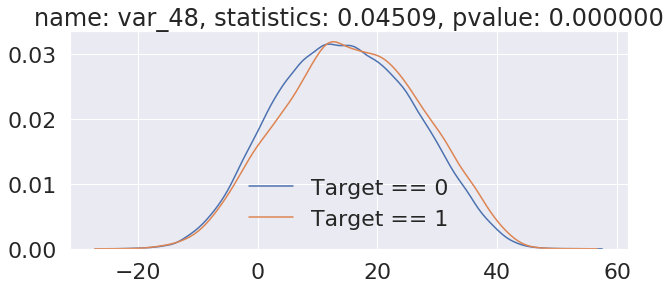

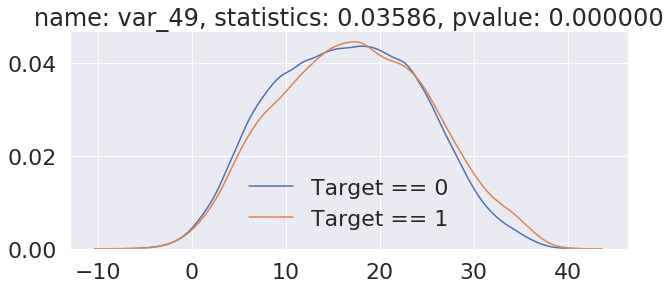

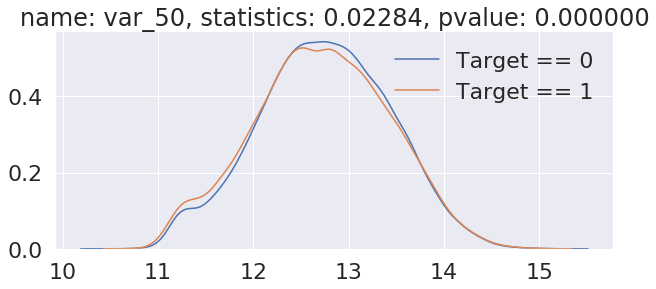

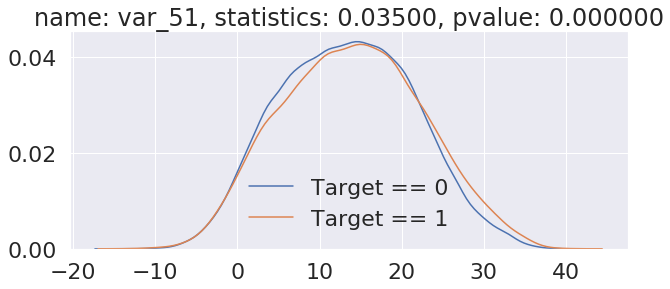

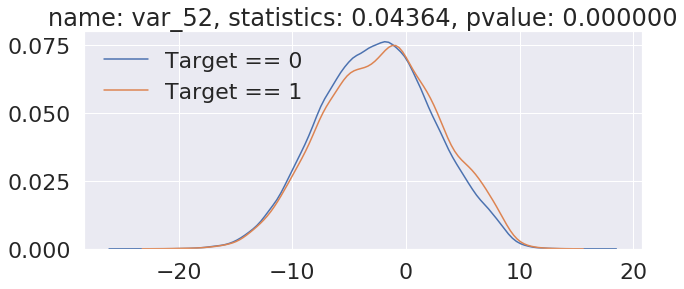

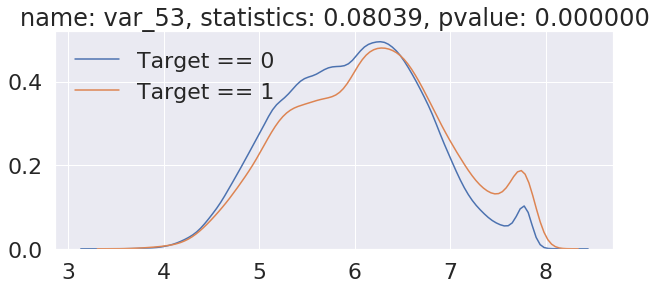

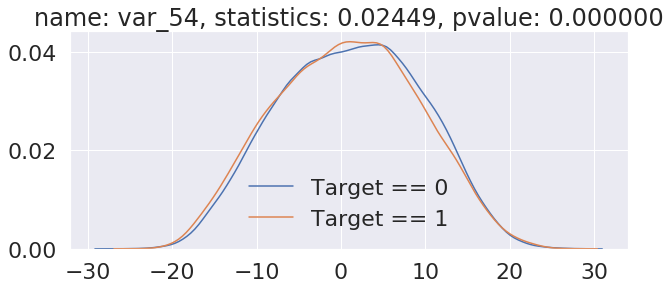

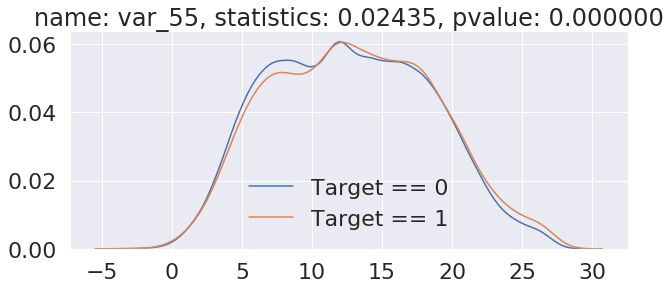

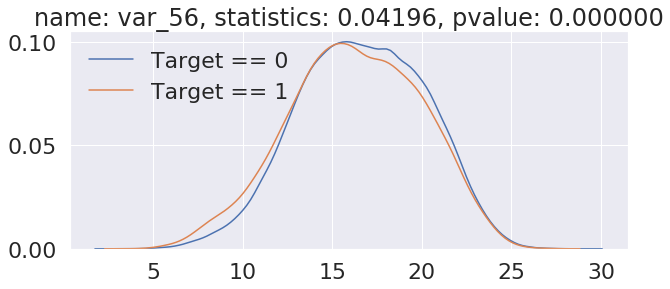

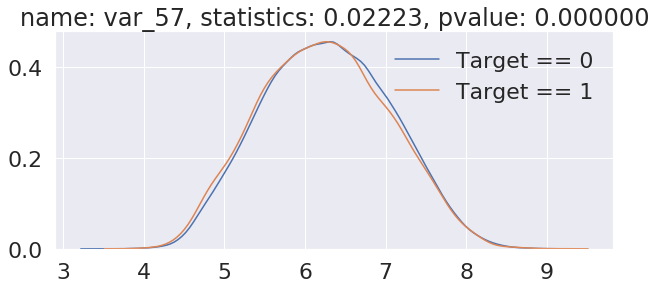

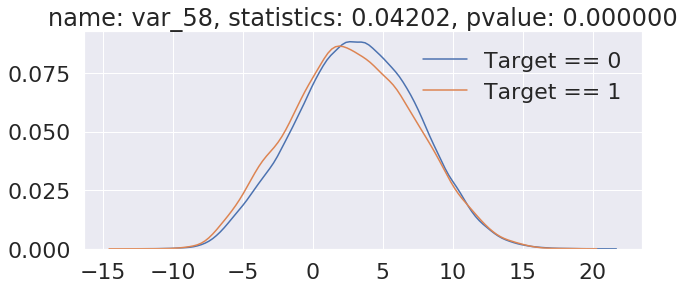

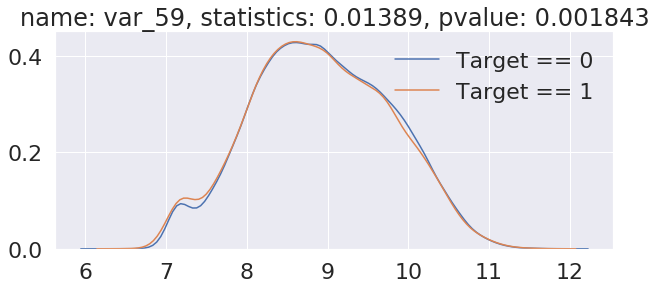

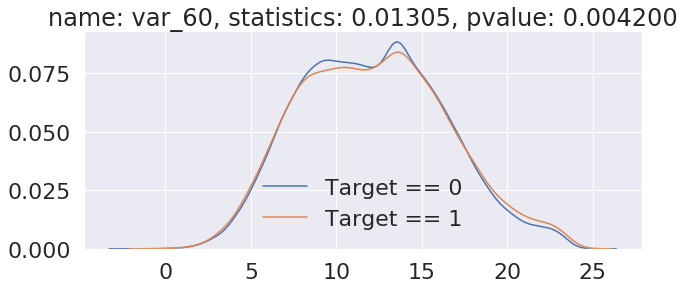

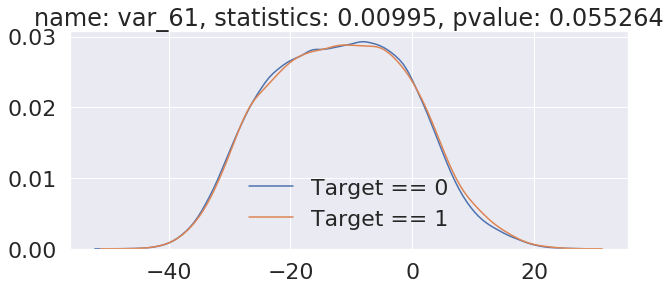

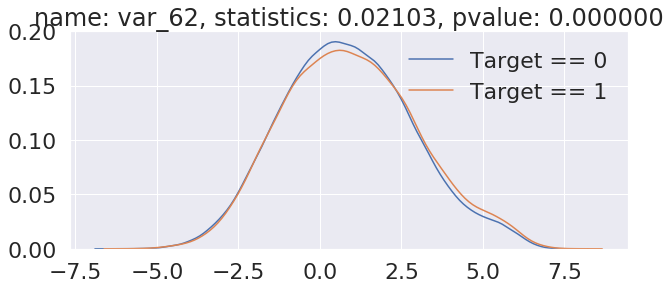

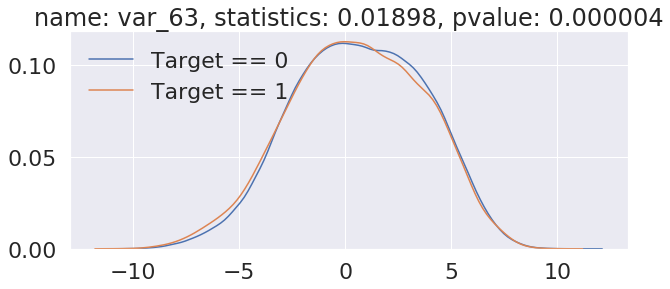

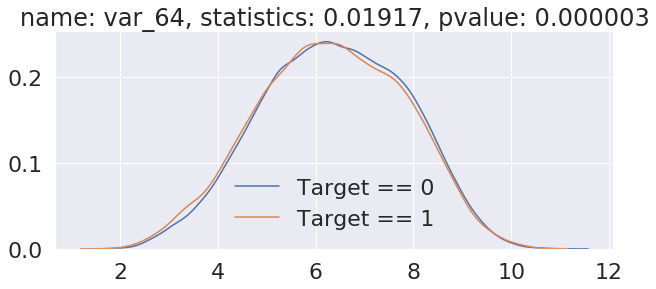

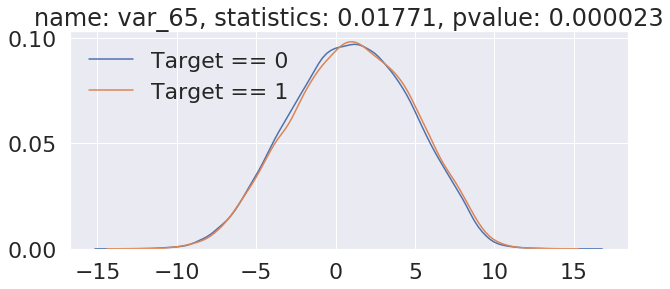

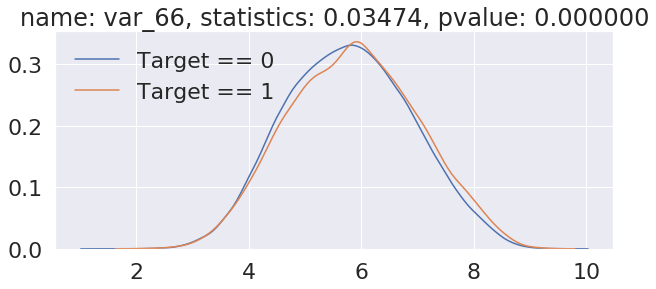

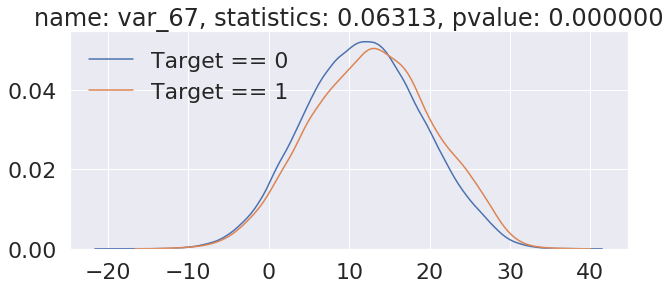

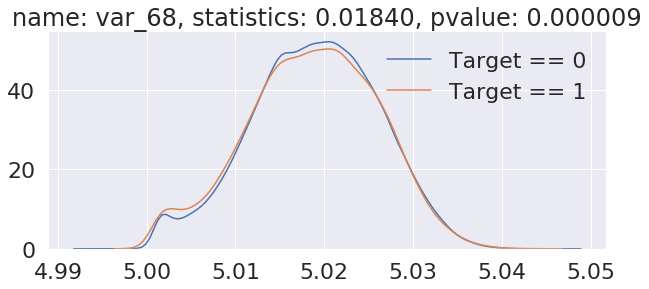

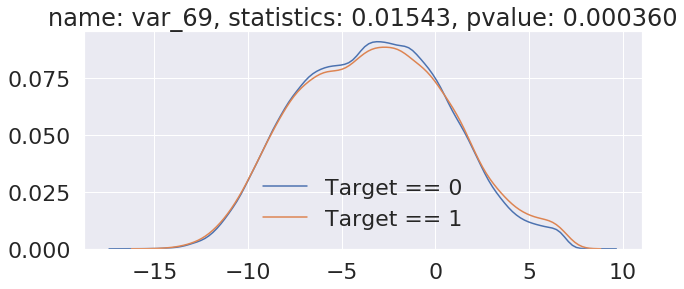

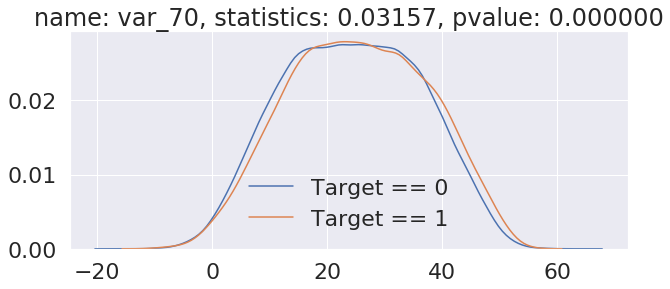

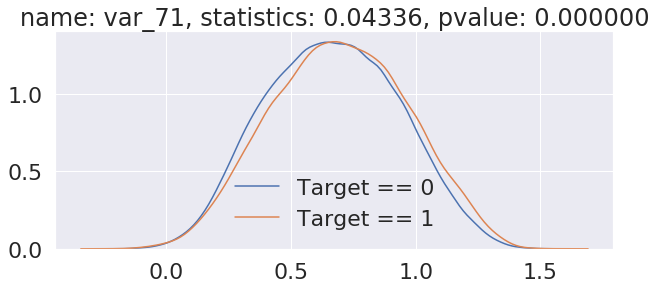

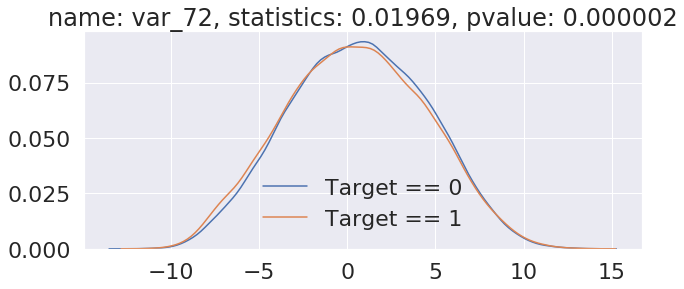

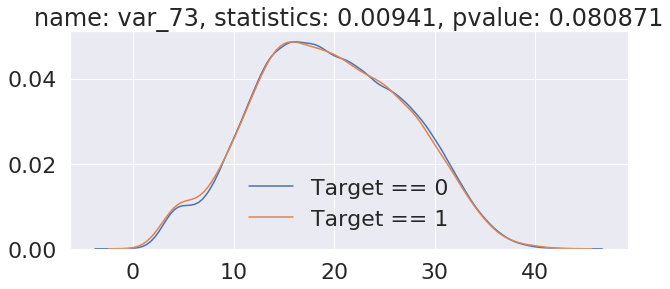

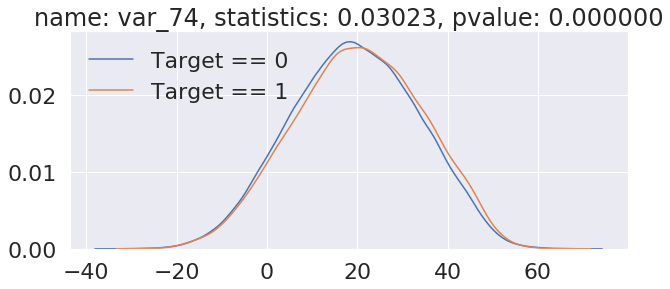

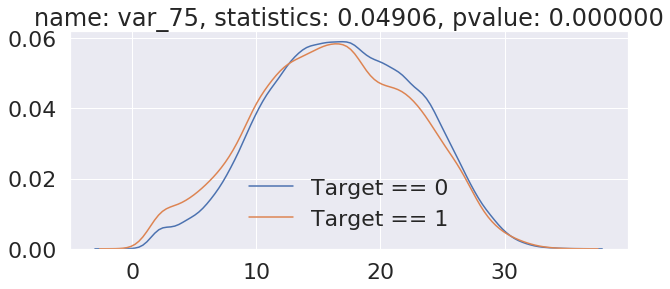

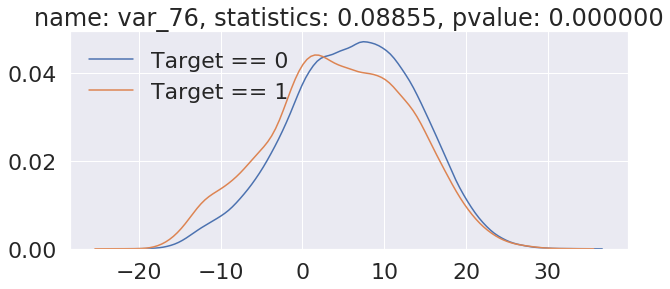

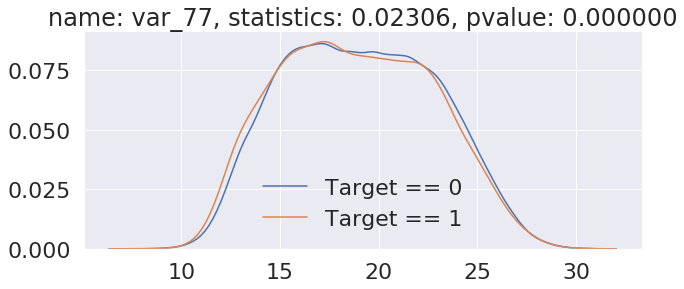

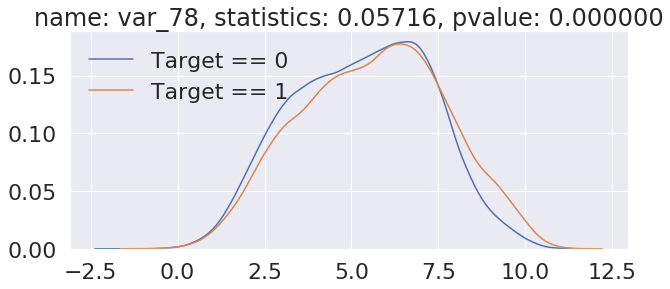

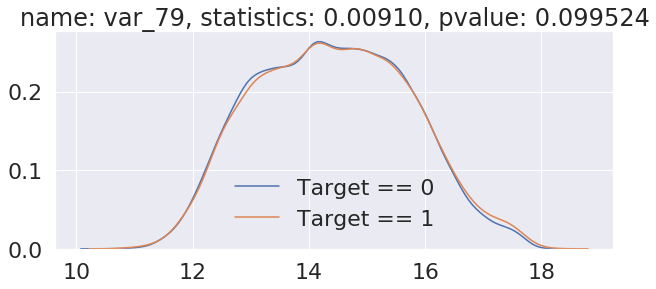

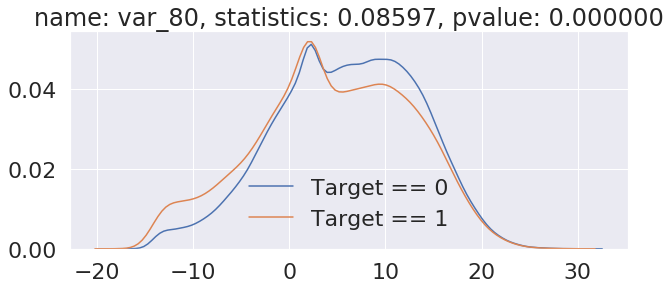

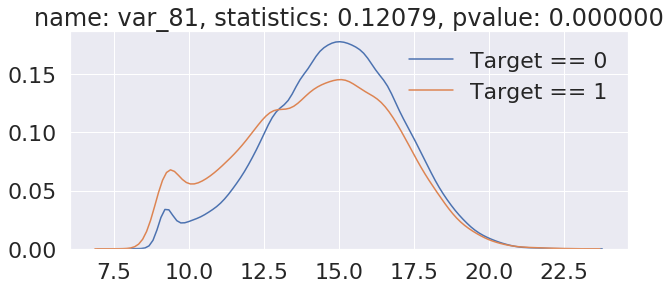

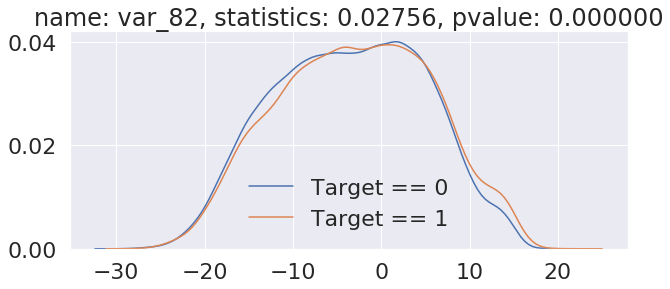

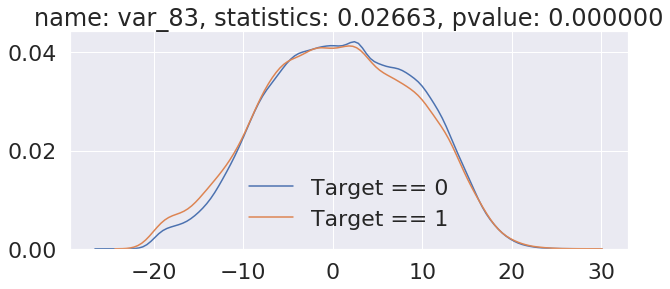

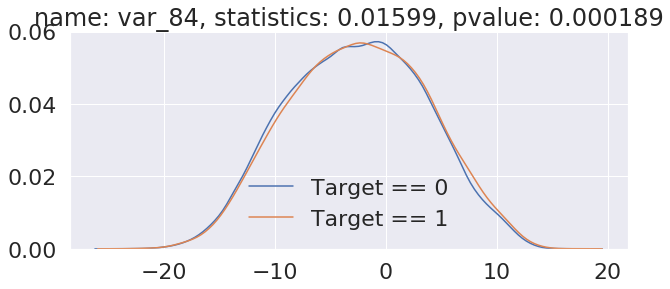

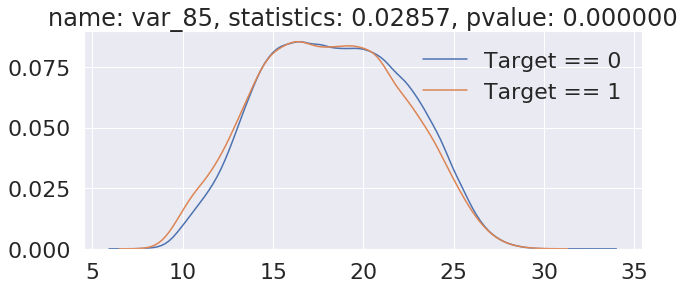

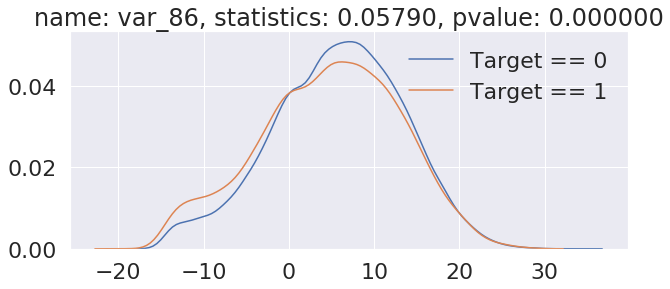

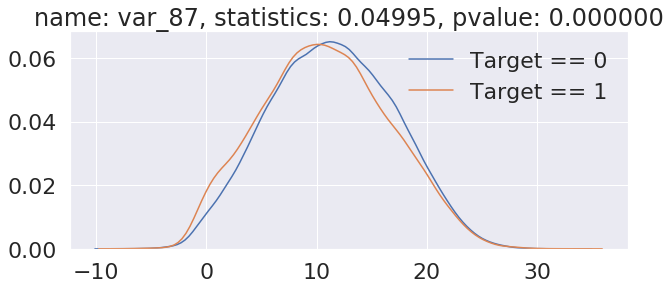

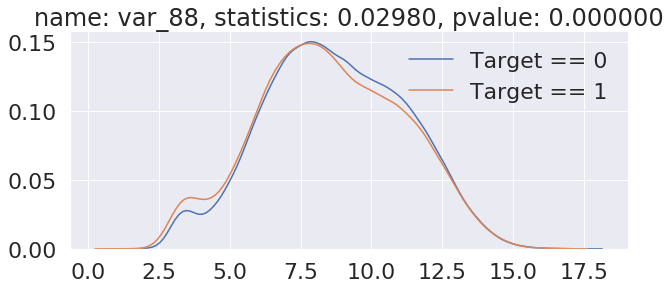

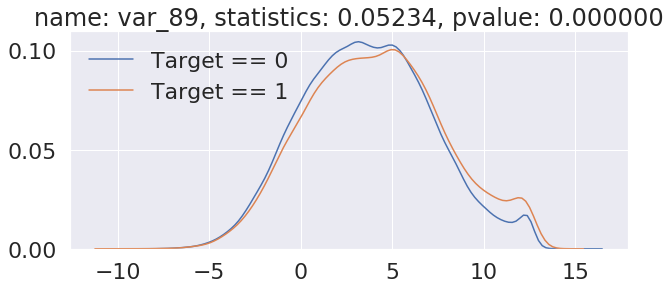

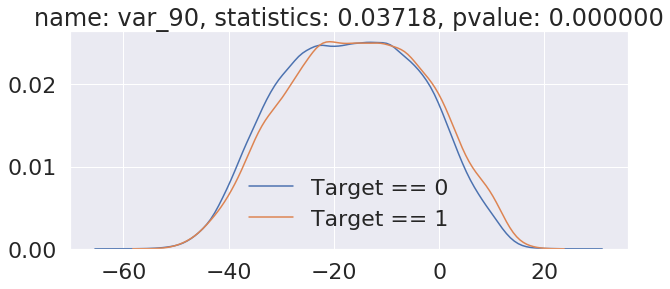

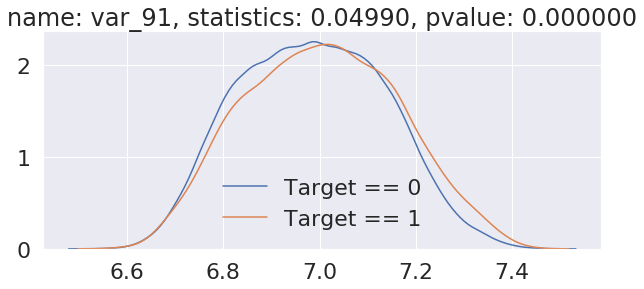

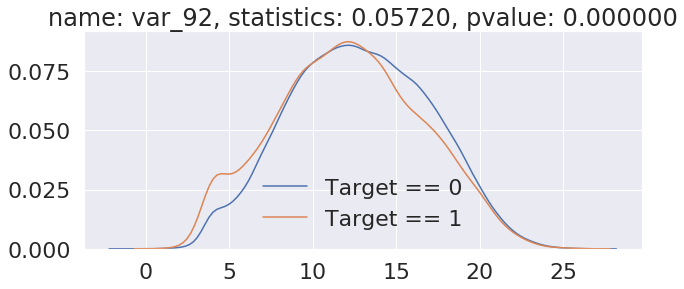

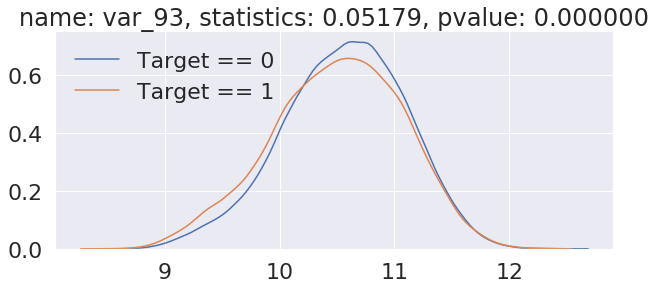

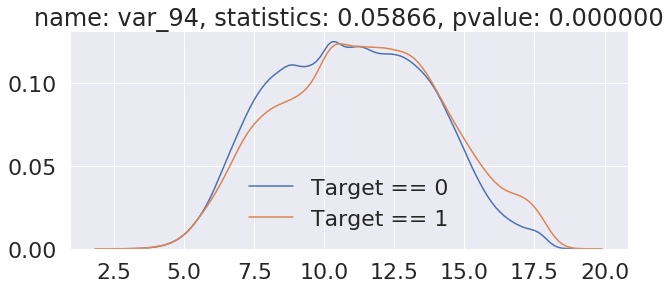

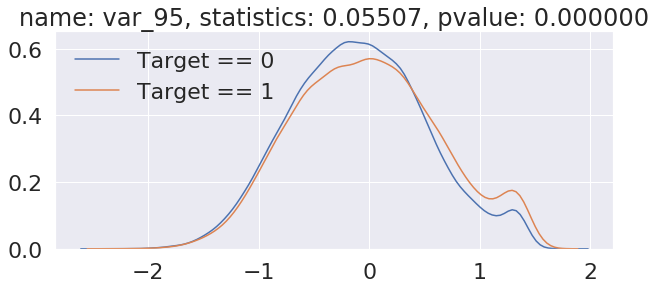

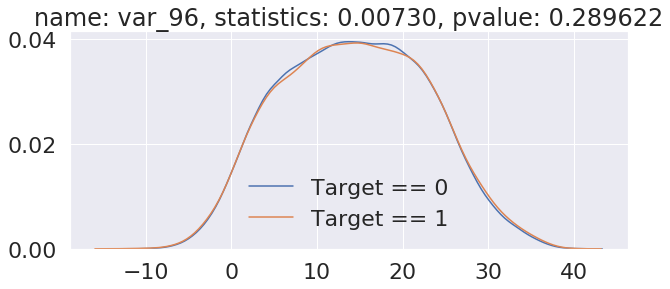

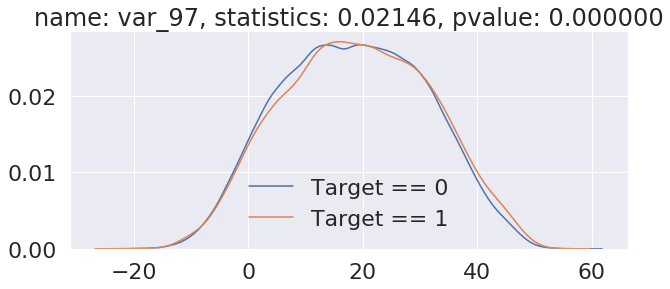

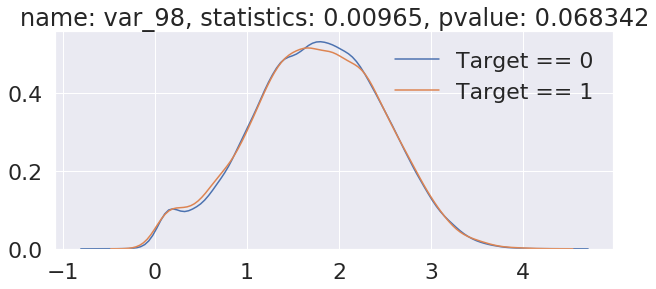

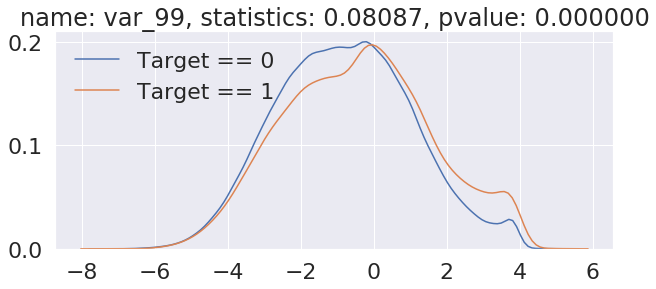

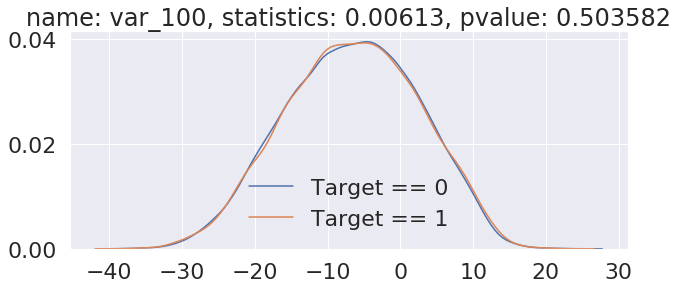

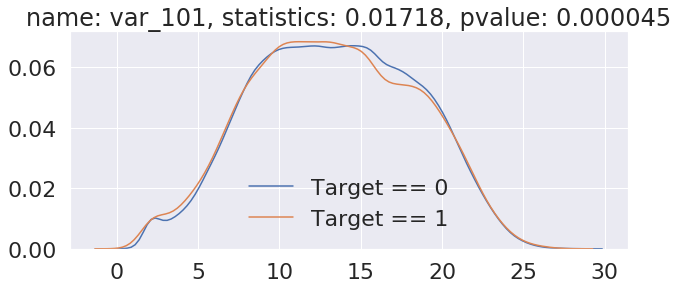

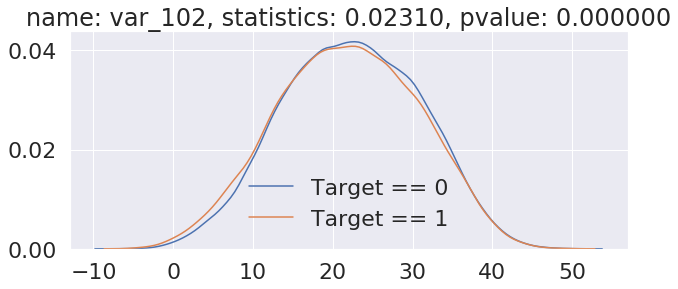

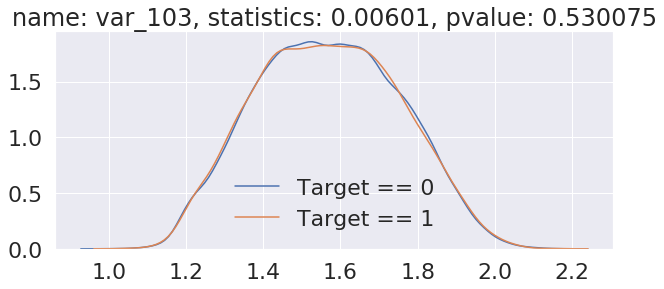

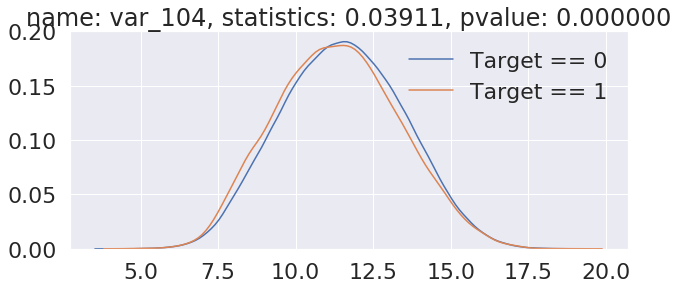

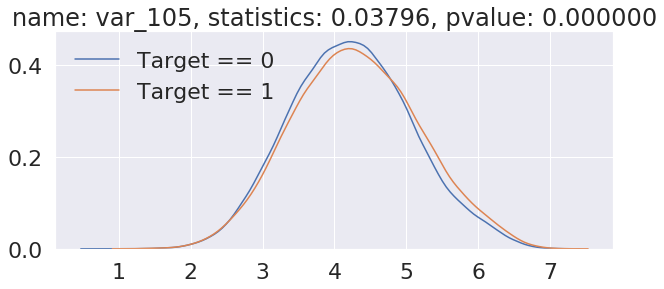

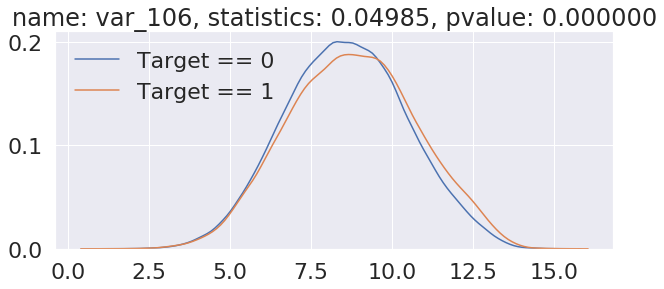

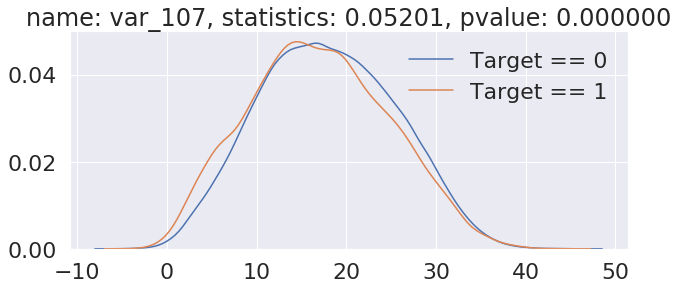

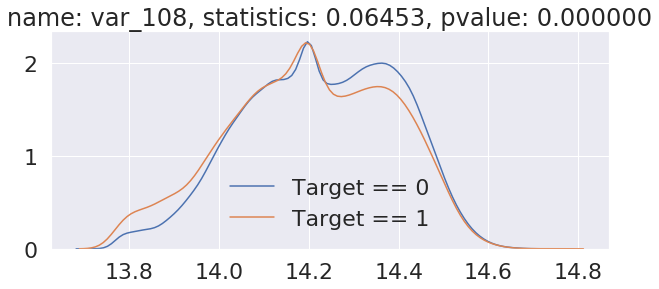

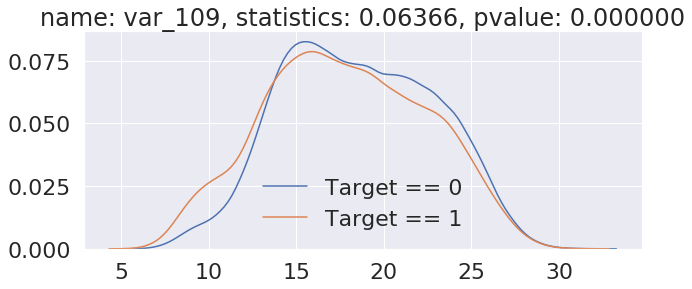

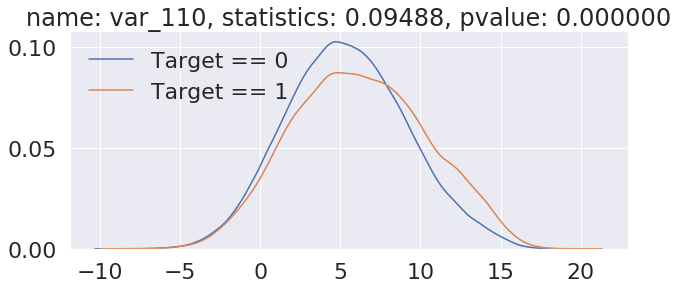

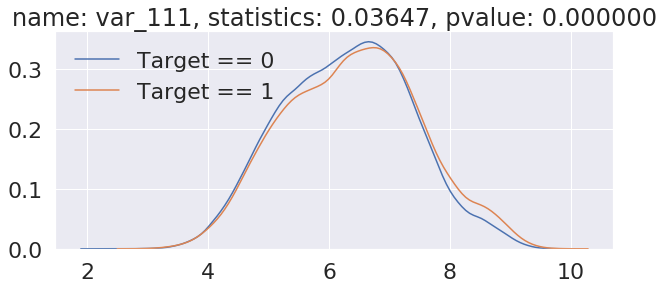

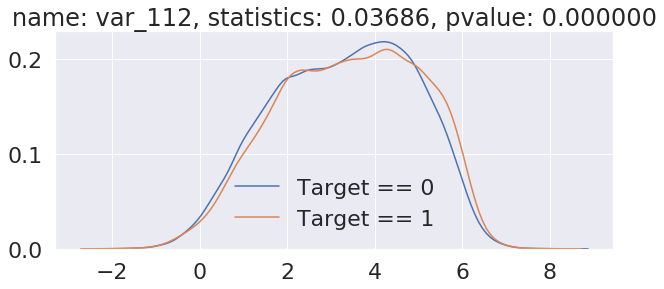

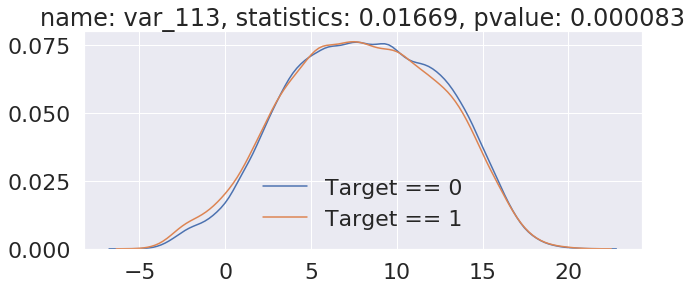

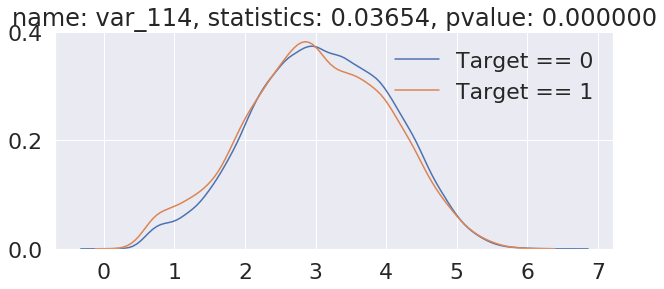

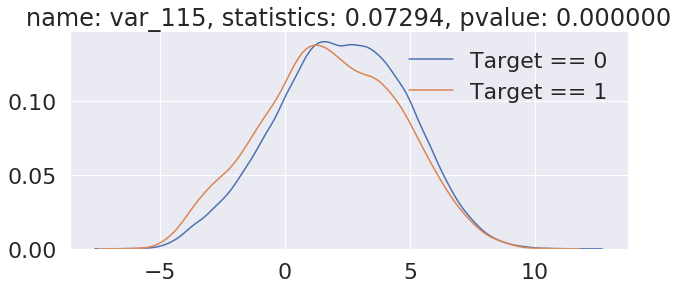

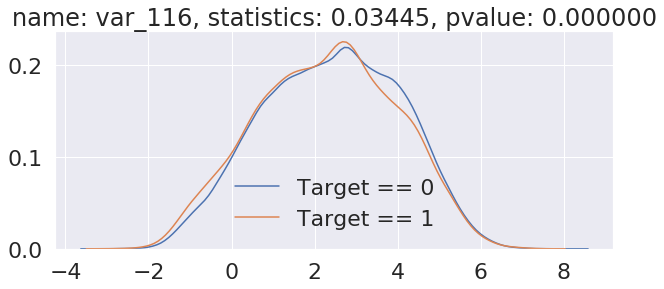

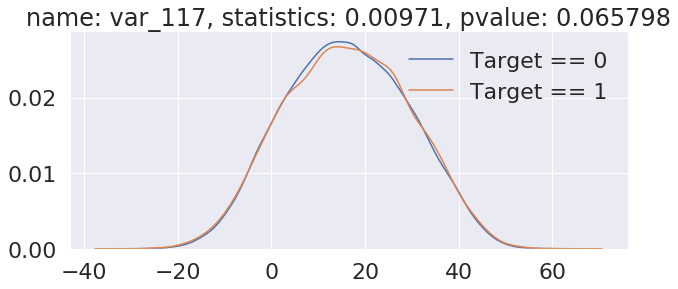

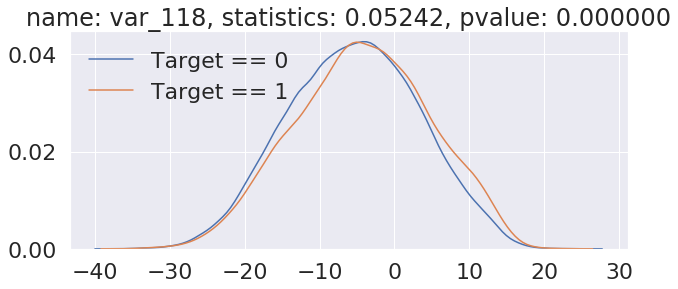

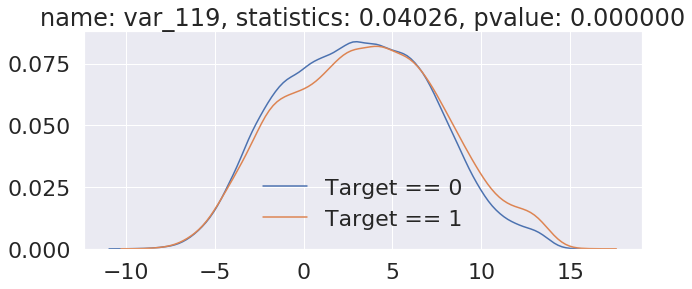

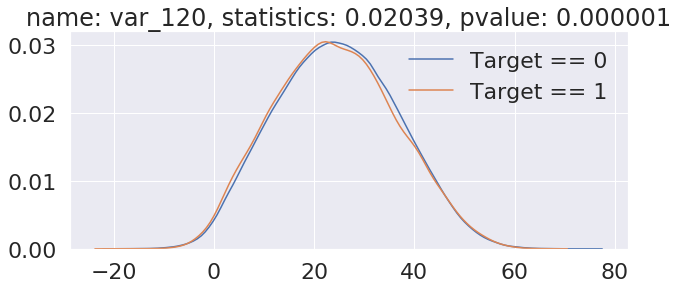

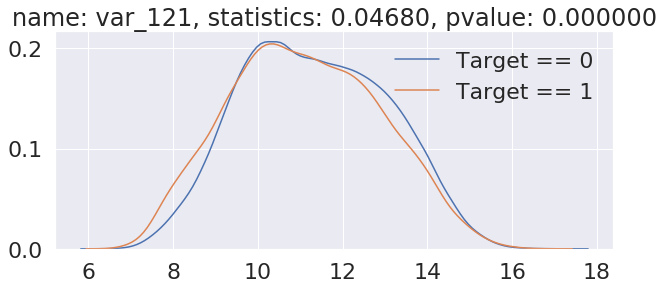

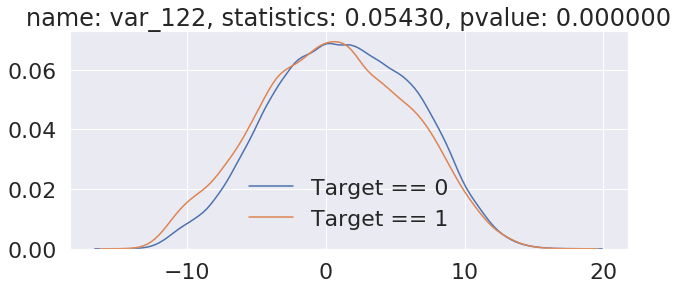

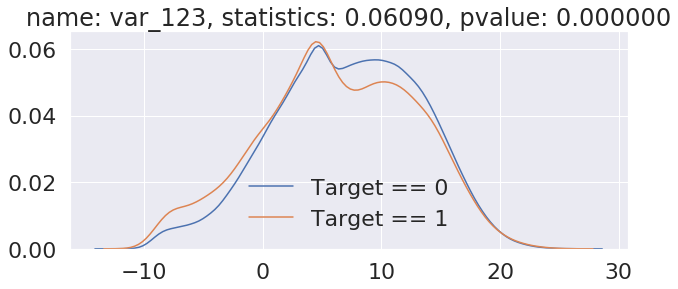

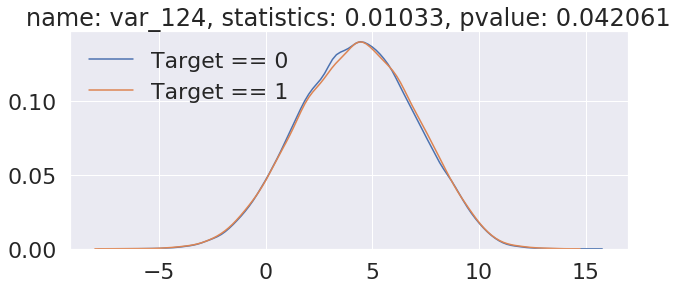

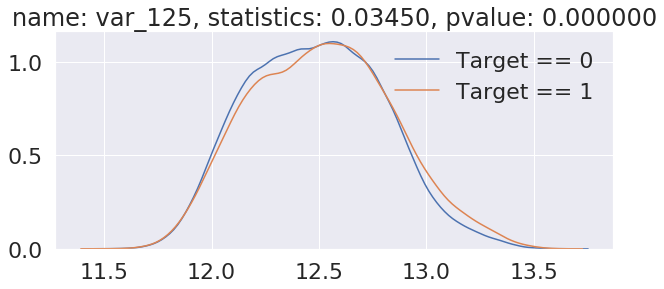

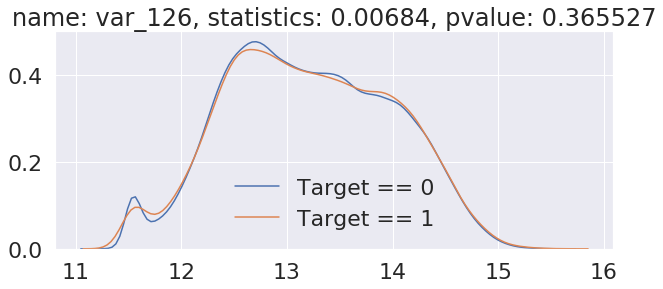

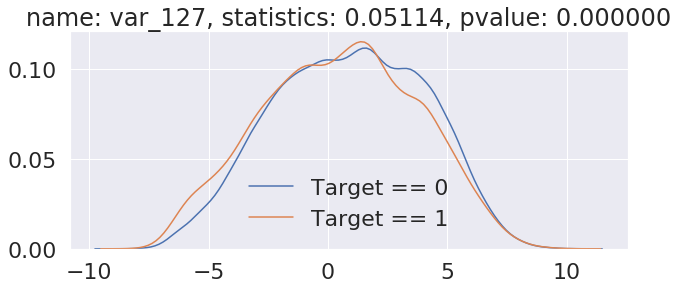

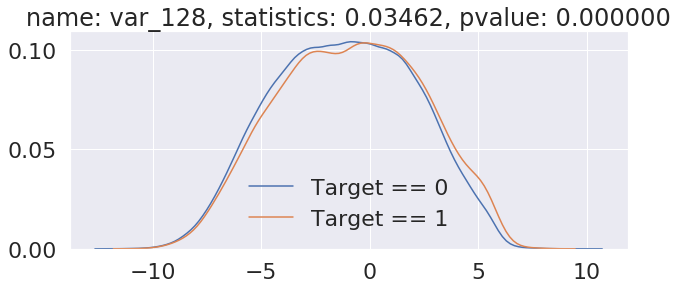

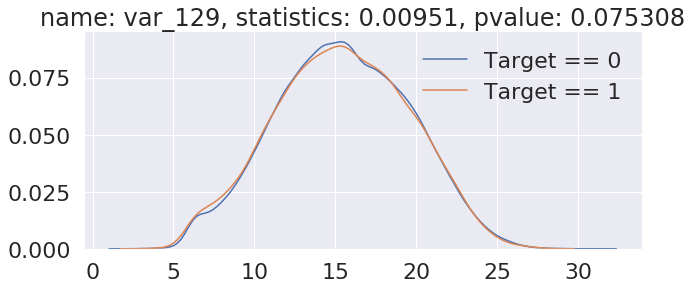

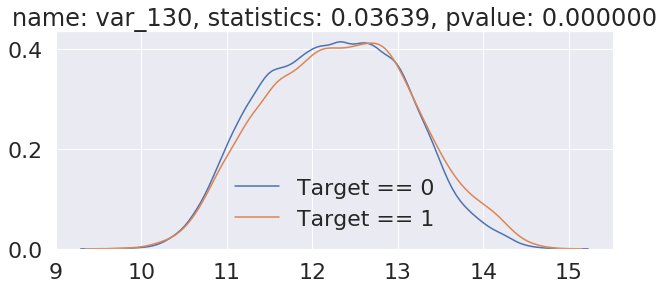

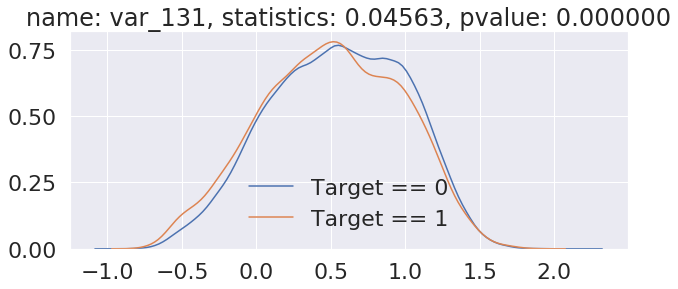

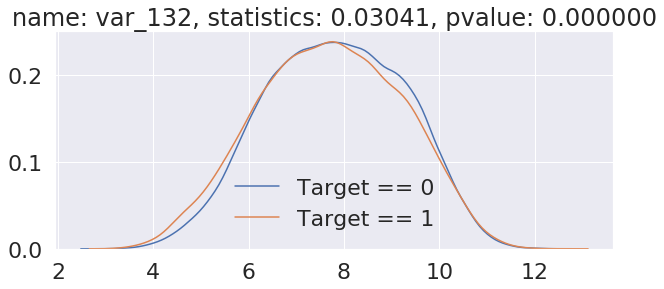

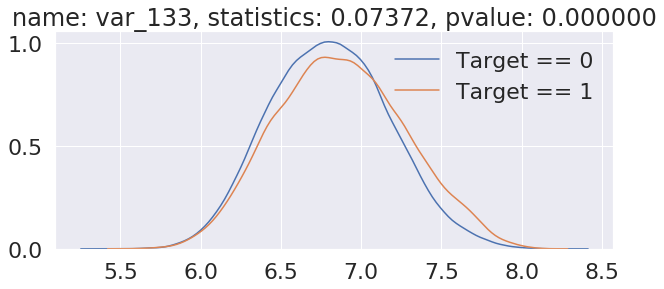

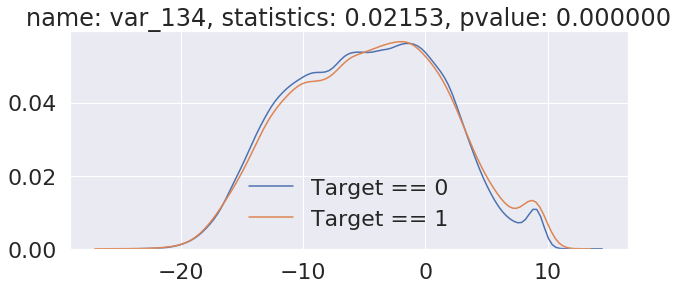

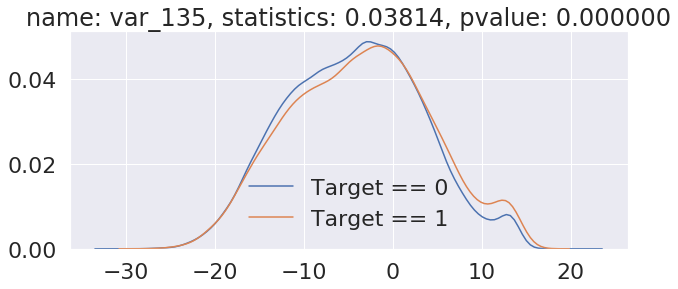

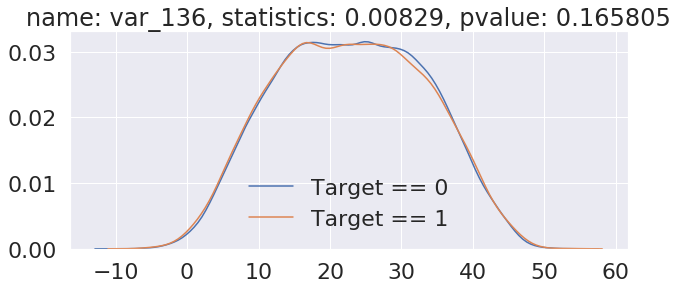

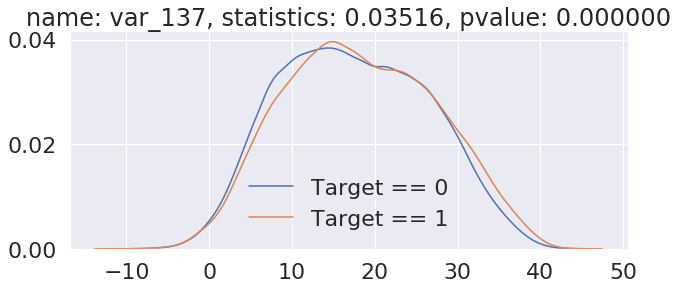

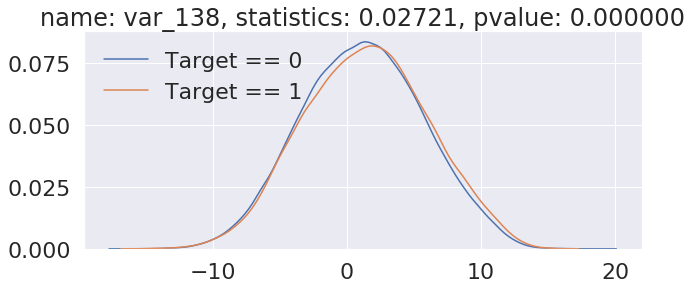

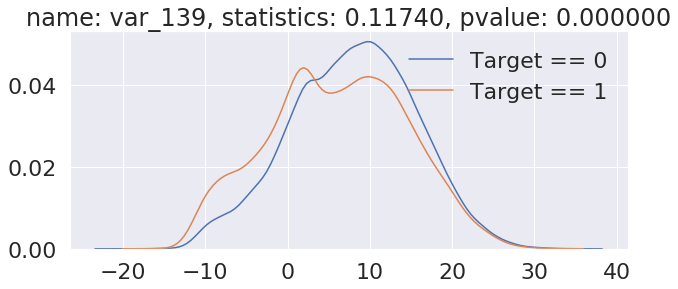

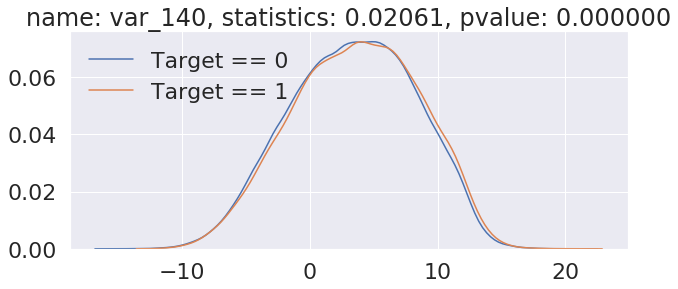

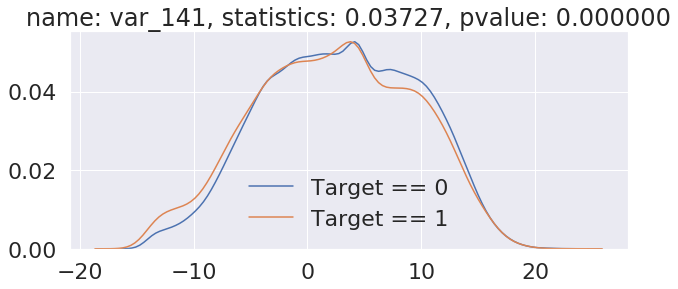

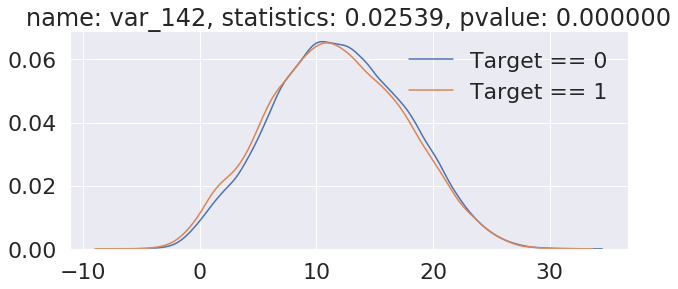

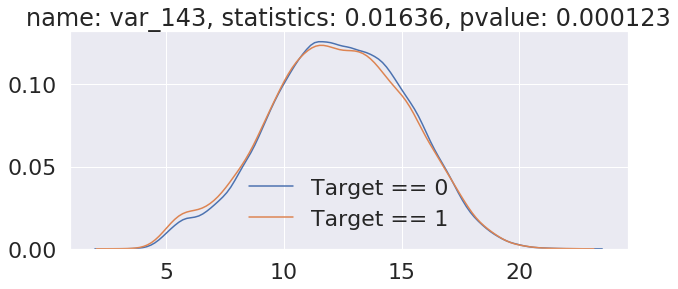

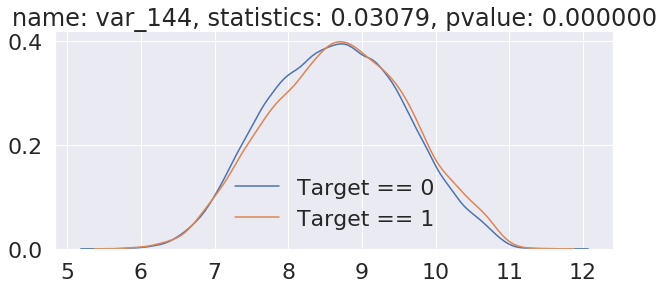

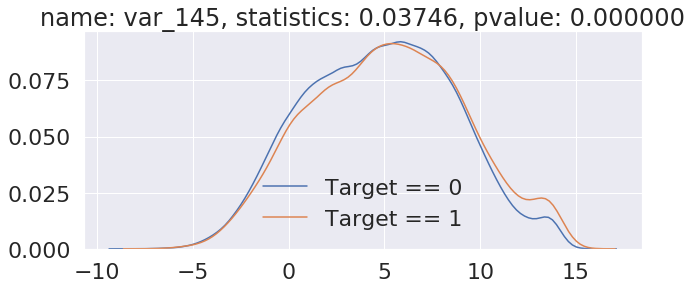

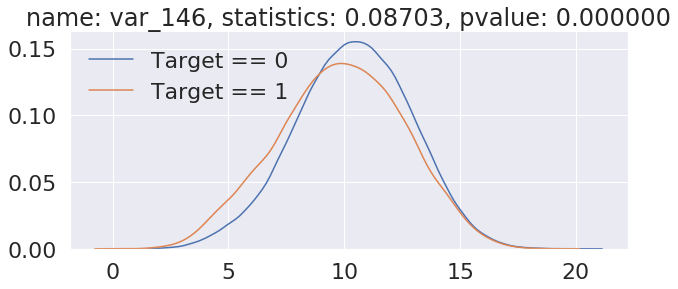

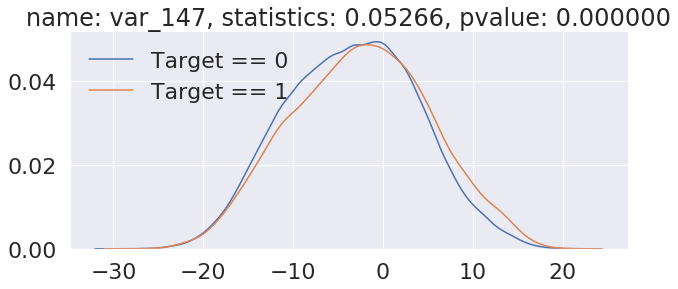

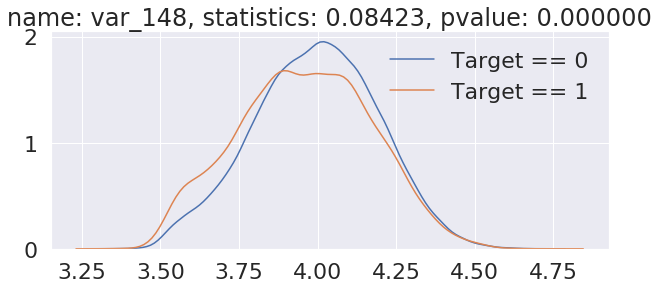

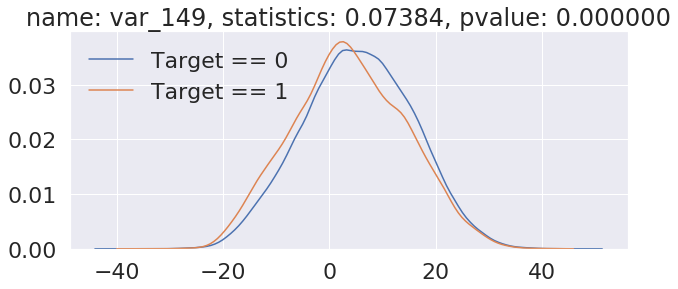

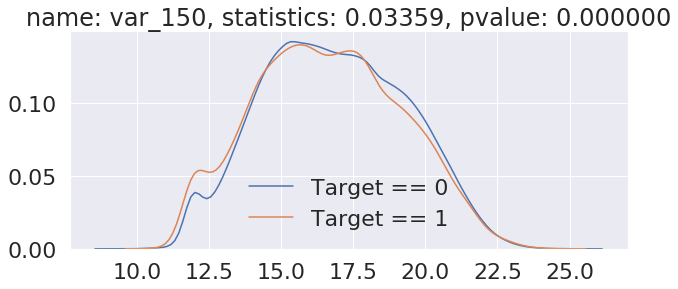

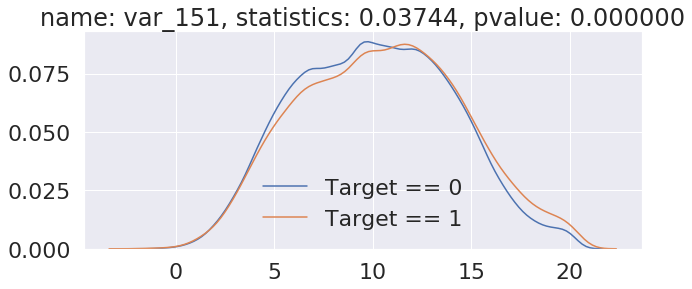

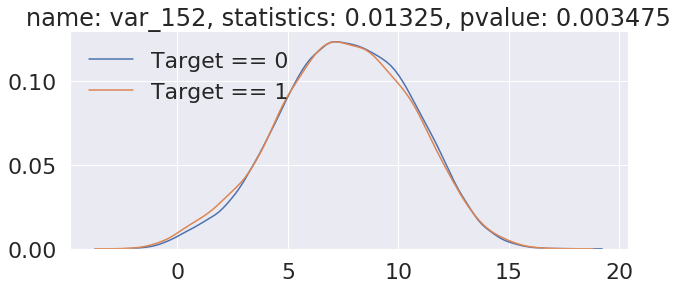

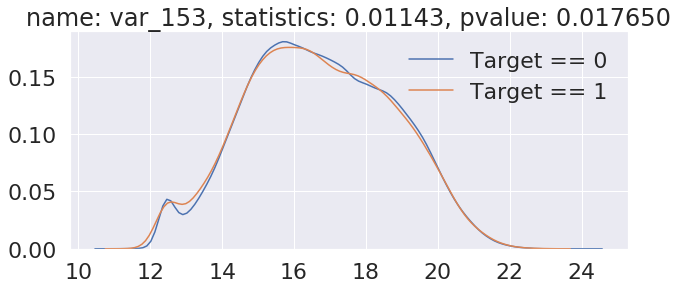

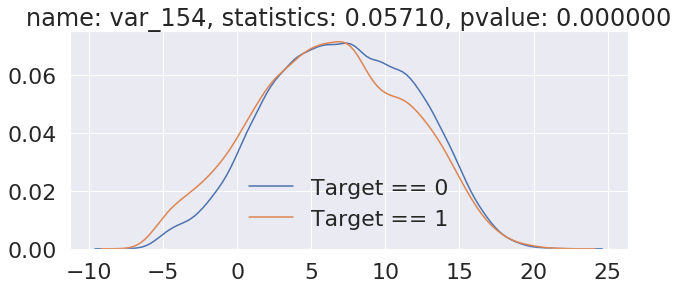

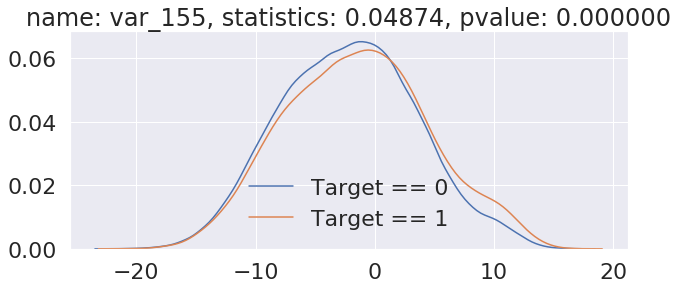

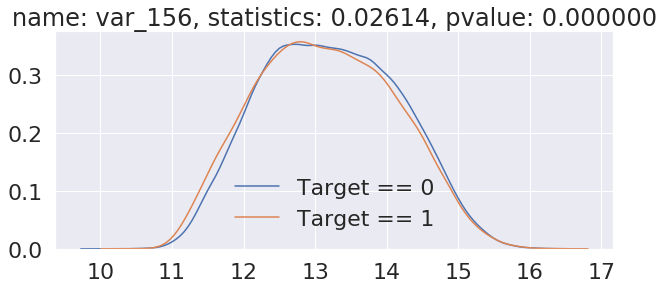

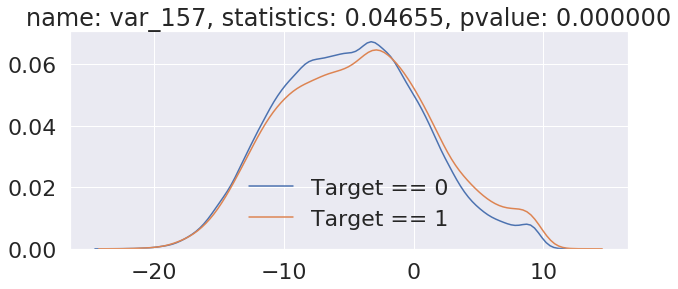

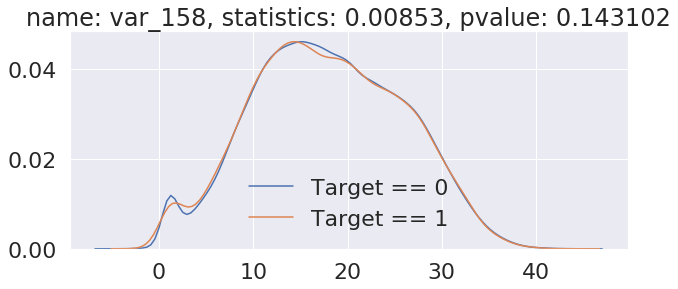

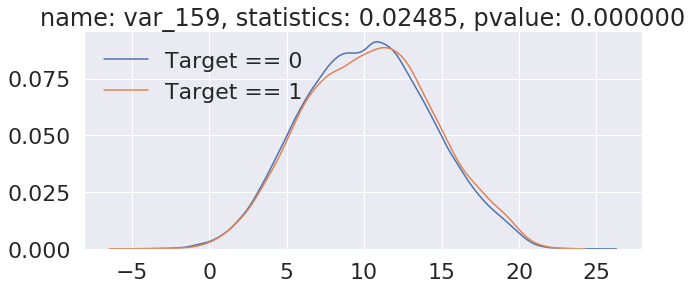

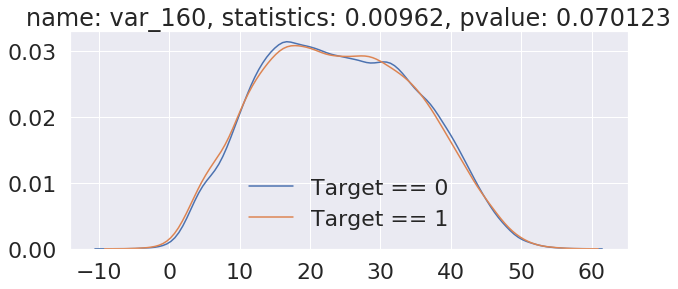

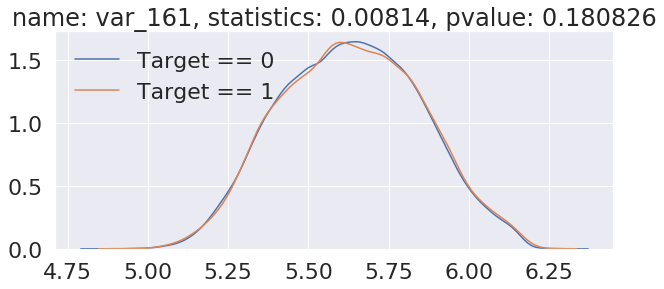

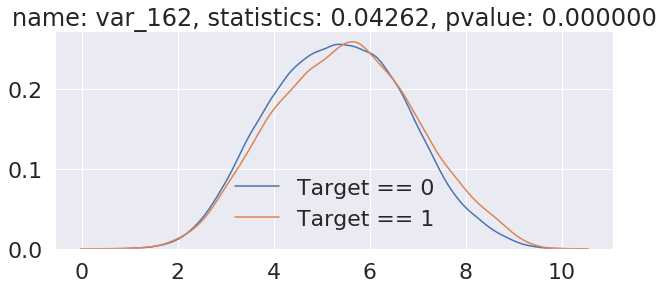

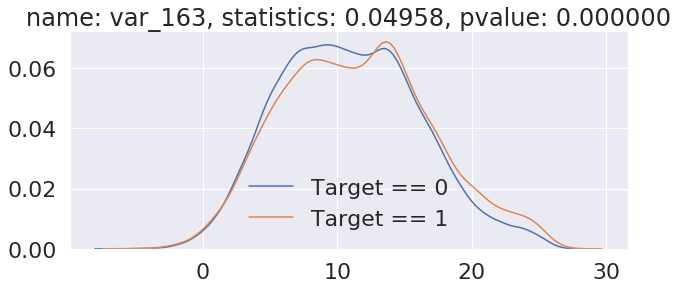

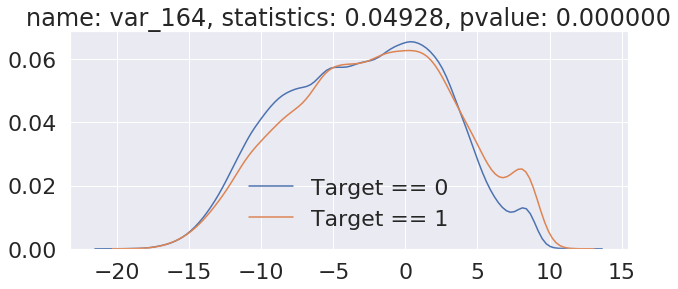

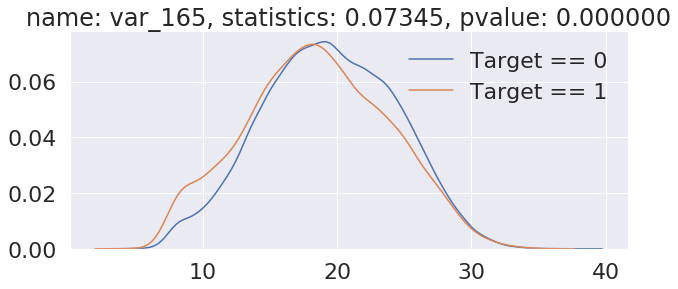

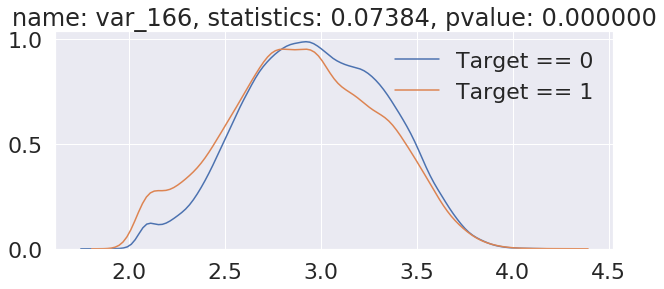

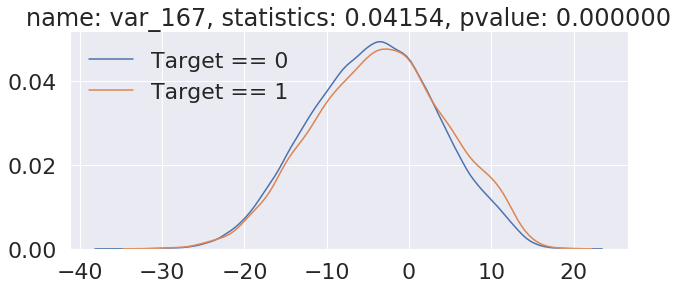

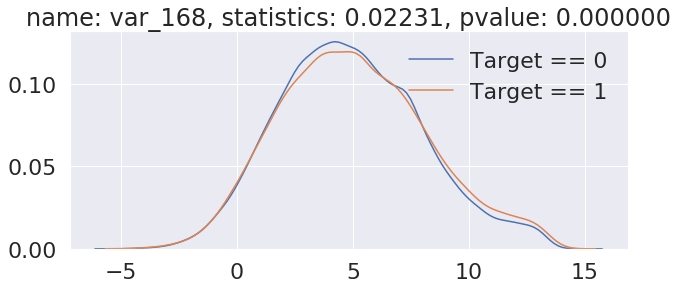

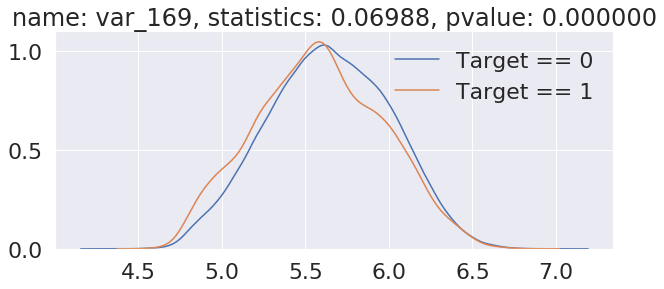

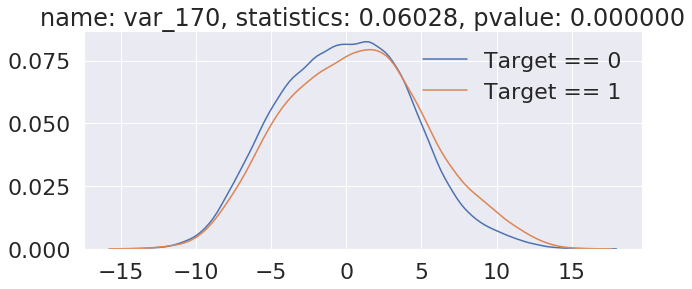

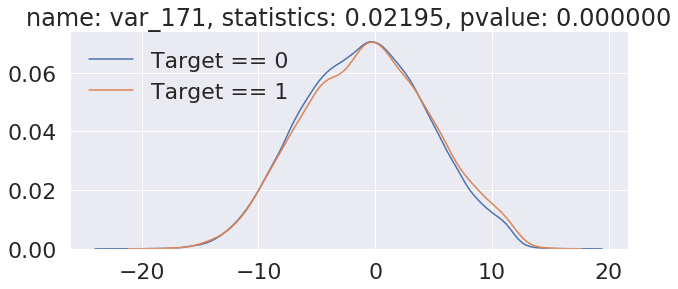

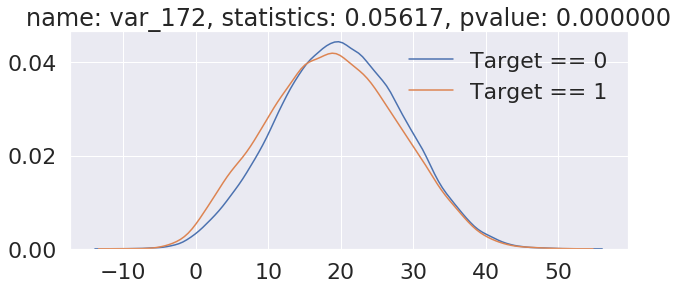

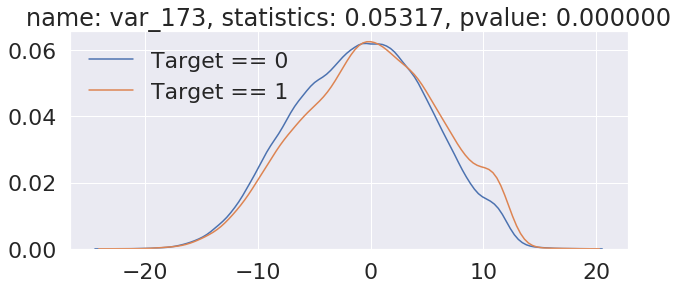

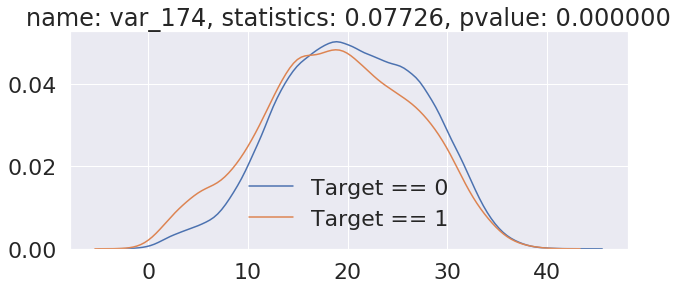

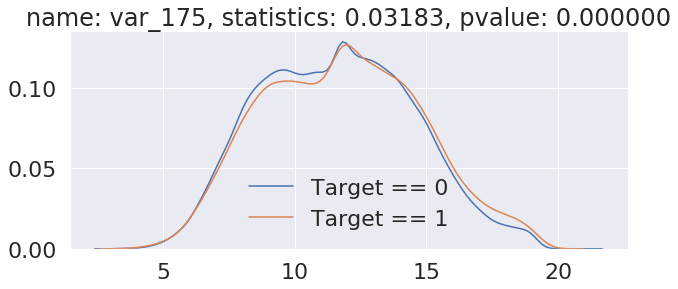

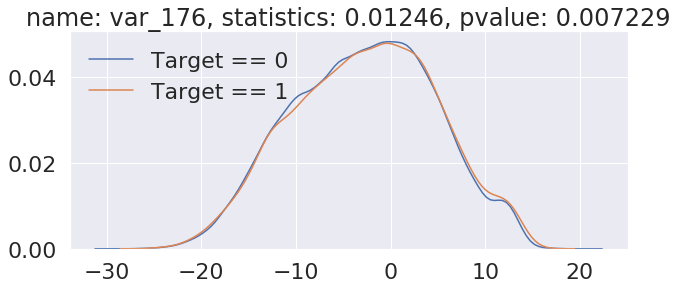

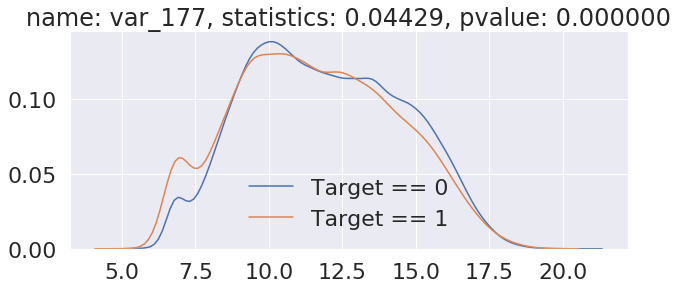

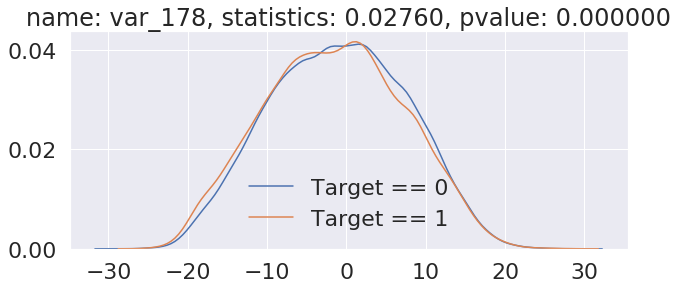

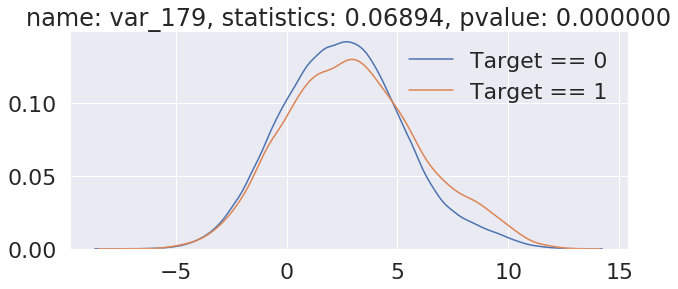

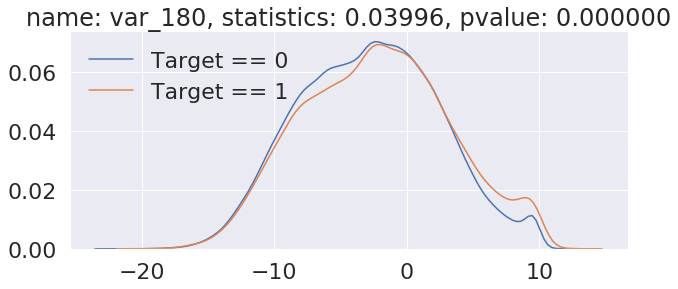

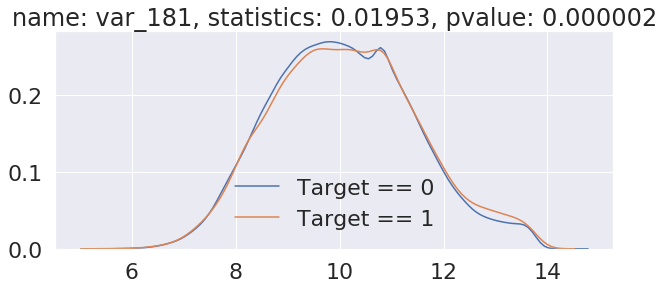

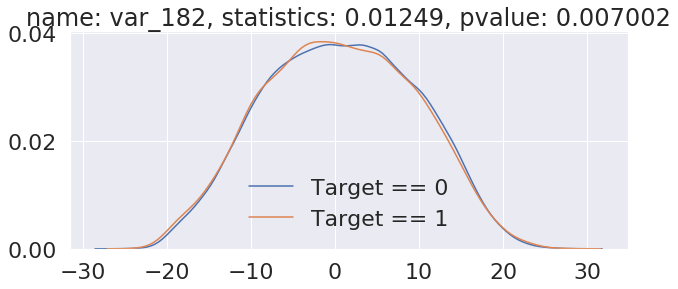

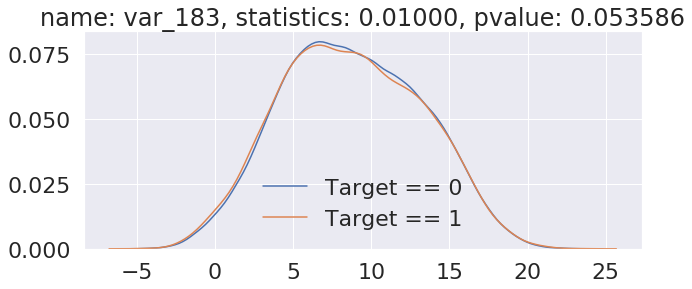

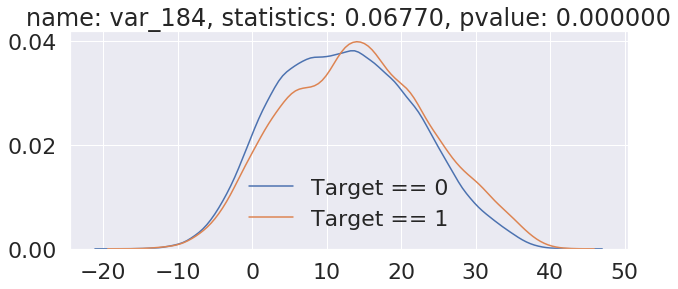

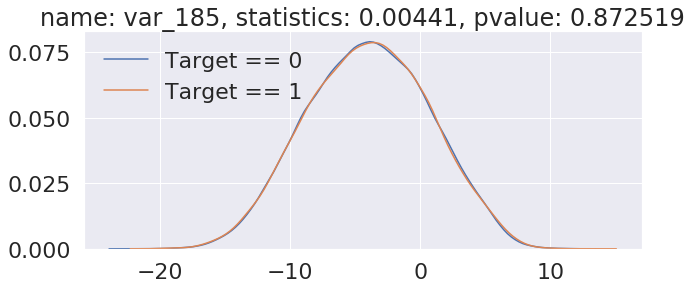

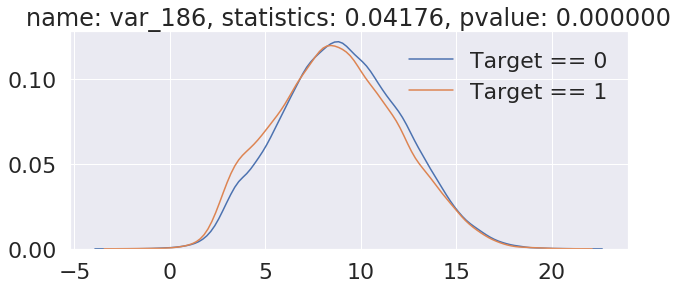

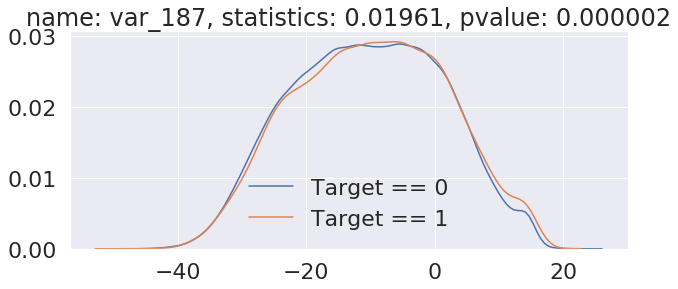

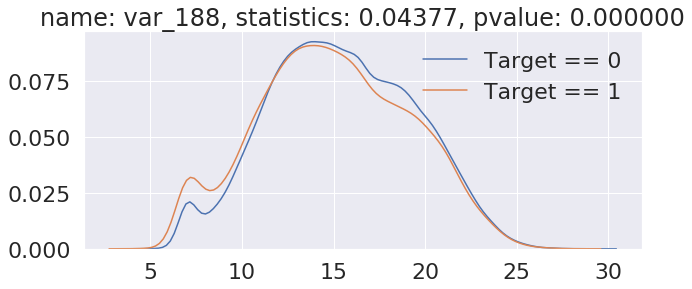

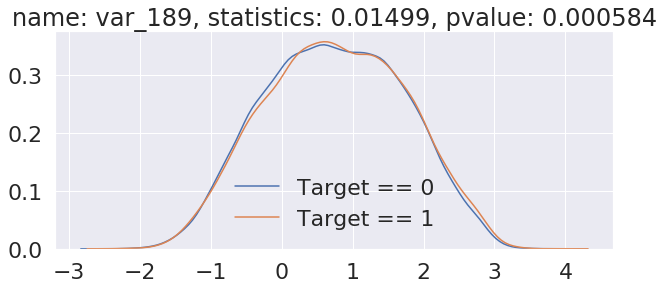

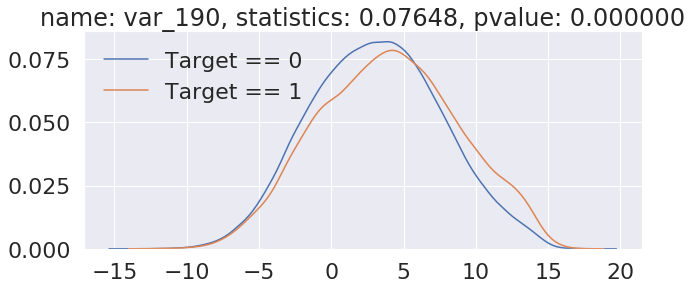

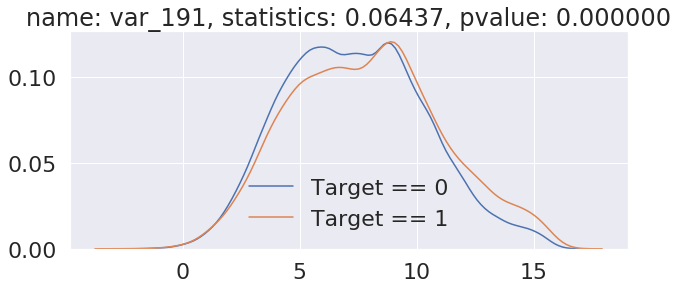

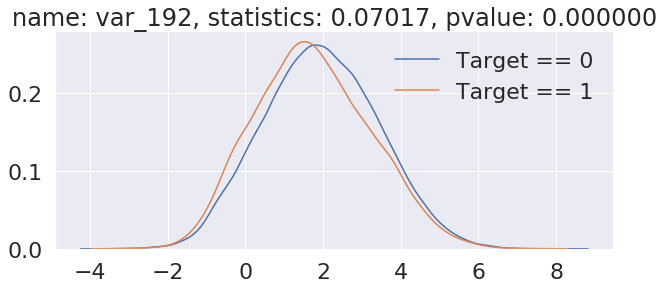

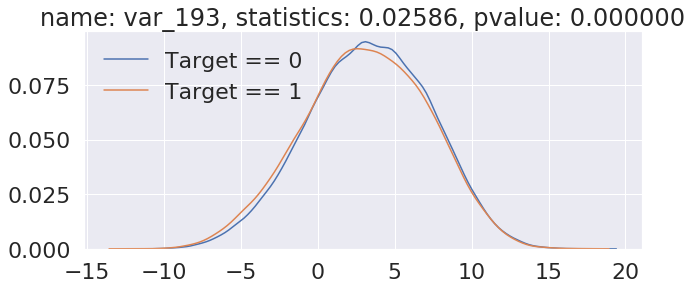

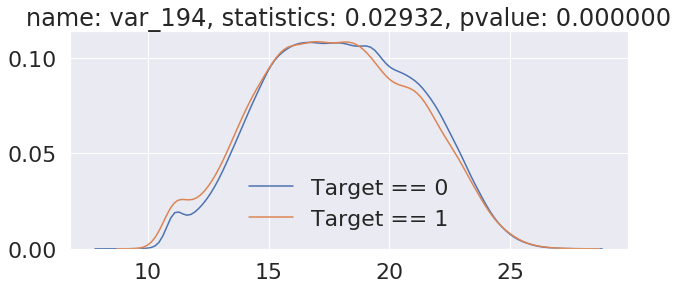

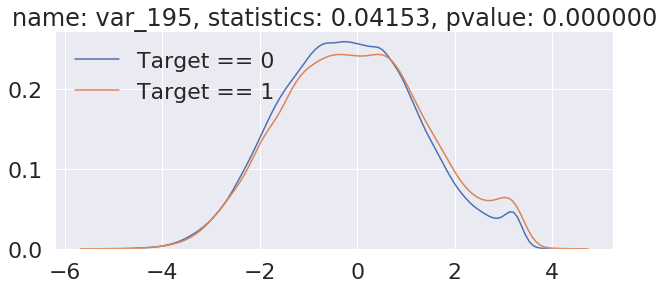

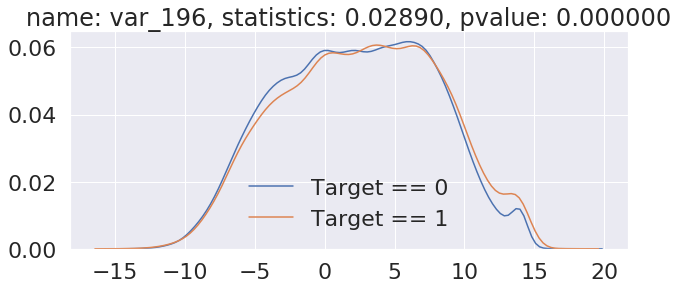

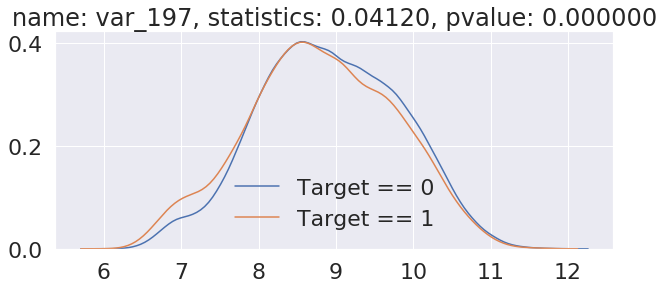

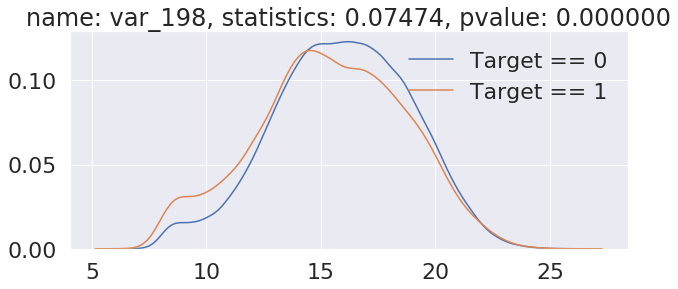

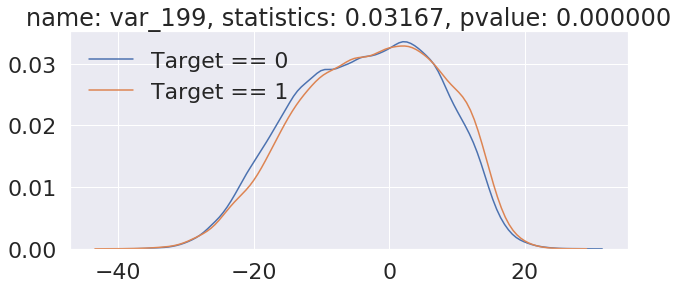

In [14]:
statistics_array = []
for col in train.columns[2:]:
    statistic, pvalue = ks_2samp(train.loc[non_target_mask, col], train.loc[target_mask, col])
    statistics_array.append(statistic)
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    sns.kdeplot(train.loc[non_target_mask, col], ax=ax, label='Target == 0')
    sns.kdeplot(train.loc[target_mask, col], ax=ax, label='Target == 1')

    ax.set_title('name: {}, statistics: {:.5f}, pvalue: {:5f}'.format(col, statistic, pvalue))
    plt.show()

# TODO

- As you know, Santander hosted other competition 6 month before.
- So you can check this competition. https://www.kaggle.com/c/santander-value-prediction-challenge

- I will do time series analysis for this dataset.